### Project Chicago: Transform ResStock PACKAGE Results for paper to 15 SFD prototypes (Elevate Energy)
Created on: 01/07/2020 \
By: Lixi Liu (Lixi.Liu@nrel.gov)

In [226]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
print(f'Notebook path: {os.getcwd()}')

Notebook path: /Users/lliu2/Documents/GitHub/ResStock/files


### Download results online
* unprocessed upgrade results: S3/resbldg-datasets/chicagoeui
* processed result tables for plots: https://nrel.sharepoint.com/sites/ChicagoRetrofits/Shared%20Documents/Forms/AllItems.aspx?viewid=289cdd1a%2D97c9%2D4bcc%2D8416%2Dc19bf01c6302&id=%2Fsites%2FChicagoRetrofits%2FShared%20Documents%2FGeneral%2FUpgrade%20results

### Initialize
For modifying plots, can go directly to section 2.3 after initialization

In [227]:
# local path to downloaded results
iteration = 'comprehensive' # <--- "paper_all", "elevate_all", "comprehensive"
iter_path = f'cookcnty_packages_{iteration}'
result_dir = '/Users/lliu2/Documents/Chicago retrofits/ResStock results'
result_path = os.path.join(result_dir, iter_path)

# number of upgrades
if iteration == 'paper_all':
    N_upgrades = 10
    n_datapoints = 40000
    n_buildings_represented = 2173433
    n_jobs = 230
elif iteration == 'elevate_all':
    N_upgrades = 19
    n_datapoints = 40000
    n_buildings_represented = 2173433
    n_jobs = 200
elif iteration == 'comprehensive':
    N_upgrades = 6
    n_datapoints = 40000
    n_buildings_represented = 2173433
    n_jobs = 185
else:
    raise ValueError(f"iteration={iteration} does not have a specified 'N_upgrades'")

## create folder for post-processed results:
if not os.path.exists(os.path.join(result_path, 'processed results')):
    os.mkdir(os.path.join(result_path, 'processed results'))
    
## create folder for exported baseline and upgrade results to csv (to share with Elevate):
combined_res_csv_path = os.path.join(result_path, 'processed results', 'processed csvs')
if not os.path.exists(combined_res_csv_path):
    os.mkdir(combined_res_csv_path)
    
## create folder for plots:
plot_path = os.path.join(result_path, 'processed results', 'plots')
if not os.path.exists(plot_path):
    os.mkdir(plot_path)

print(f'Results path: \n   {result_path}')


Results path: 
   /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_comprehensive


### Functions

In [228]:
def get_per_unit_sim_output(df, ref):
    """
    ref (df): baseline df
    """
    cols = [x for x in df.columns if 
            x.endswith('_kwh') or
            x.endswith('_mbtu') or
            x.endswith('_therm') or
            x.endswith('_cost_usd') or
            x.endswith('_ft_2')
           ]
    res = ref.set_index('building_id').reindex(df['building_id']).reset_index()
    df.loc[:, cols] = df.loc[:, cols].replace([None,''],np.nan).divide(
        res['build_existing_model.units_represented'], axis=0)
    
    return df
print('func loaded: "get_per_unit_sim_output"')

def get_per_unit_sim_output_limited(df, ref):
    """
    To reduce computing time
    ref (df): baseline df
    """
    cols = ['simulation_output_report.total_site_natural_gas_therm',
            'simulation_output_report.total_site_electricity_kwh',
            'simulation_output_report.total_site_energy_mbtu',
            'simulation_output_report.upgrade_cost_usd'
           ]
    res = ref.set_index('building_id').reindex(df['building_id']).reset_index()
    df.loc[:, cols] = df.loc[:, cols].replace([None,''],np.nan).divide(
        res['build_existing_model.units_represented'], axis=0)
    
    return df
print('func loaded: "get_per_unit_sim_output_limited"')

def add_sqft_eui(df, ref):
    """
    ARG:
        ref (df): baseline df
    RETURN:
        df with added cols: 'sqft', 'gas_eui_thermpersqft','elec_eui_kwhpersqft','site_eui_kbtupersqft'
    """
    res = ref.set_index('building_id').reindex(df['building_id']).reset_index()
    df['sqft'] = res['simulation_output_report.floor_area_conditioned_ft_2']
    df['gas_eui_thermpersqft'] = df['simulation_output_report.total_site_natural_gas_therm'].divide(df['sqft']) # therm/sqft
    df['elec_eui_kwhpersqft'] = df['simulation_output_report.total_site_electricity_kwh'].divide(df['sqft']) # kwh/sqft
    df['site_eui_kbtupersqft'] = df['simulation_output_report.total_site_energy_mbtu'].divide(df['sqft'])*1000 # kbtu/sqft
    
    for col in ['sqft','gas_eui_thermpersqft','elec_eui_kwhpersqft','site_eui_kbtupersqft']:
        df.loc[df['simulation_output_report.applicable']==False, col] = np.nan
    
    return df
print('func loaded: "add_sqft_eui"')

def get_res_by_prototype(df, filter_by_df, row):
    """
    ARG:
        df (dataframe): df to slice on
        filter_by_df (dataframe): df used to do the slicing
    RETURN:
        filtered df (dataframe)
    """
    slice_by_df = filter_by_df.copy().set_index('building_id').reindex(df['building_id']).reset_index()
    res_group_i = df[slice_by_df['build_existing_model.geometry_stories'].isin(row['Stories'].split(',')) & \
        slice_by_df['build_existing_model.geometry_wall_type'].isin(row['WallType'].split(',')) & \
        slice_by_df['build_existing_model.vintage_acs'].isin(row['Vintage'].split(',')) & \
        slice_by_df['build_existing_model.geometry_building_type_recs'].isin(['Single-Family Detached'])]
    res_group_i = res_group_i[res_group_i['completed_status']=="Success"]
    
    return res_group_i
print('func loaded: "get_res_by_prototype"')

def load_upgrade(n, file_dir=result_path):
    """
    ARG:
        n (int, str): upgrade number
        file_dir (str): folder in which upgrade can be found, default to main result dir
    RETURN:
        df (dataframe) of upgrade n
    """
    df = pd.read_parquet(os.path.join(file_dir,'upgrades',
                                     f'upgrade={n}/results_up{n:02d}.parquet'))
    return df
print('func loaded: "load_upgrade"')



func loaded: "get_per_unit_sim_output"
func loaded: "get_per_unit_sim_output_limited"
func loaded: "add_sqft_eui"
func loaded: "get_res_by_prototype"
func loaded: "load_upgrade"


### 1. BASELINE results

In [229]:
save_a_copy_in_csv = True # <-----
res = pd.read_parquet(os.path.join(result_path,'baseline','results_up00.parquet'))

# (1) get sqft, gas/elec/site eui
res = add_sqft_eui(res, res)
sample_weight = n_buildings_represented / n_datapoints
res['build_existing_model.sample_weight'] = sample_weight
    
# (1) get sim output at the unit level (req for MF)
res = get_per_unit_sim_output(res, res)

# (2) get sqft, gas/elec/site eui - redo to get unit-level results
res = add_sqft_eui(res, res)

# check
jobs_missing = set(range(1,n_jobs+1)) - set(res.job_id.unique())
bldgs_missing = n_datapoints-len(res)
print(f'- {len(jobs_missing)} jobs missing: {jobs_missing}')
print(f'- {bldgs_missing} buildings ({(bldgs_missing/n_datapoints*100):.2f}%)')

if bldgs_missing > 0:
    orig_sample_weight = sample_weight
    sample_weight = n_buildings_represented / (n_datapoints-bldgs_missing)
    print("* adjusting 'sample_weight' from "
          f"{orig_sample_weight} to "
          f"{sample_weight}")
    res['build_existing_model.sample_weight'] = sample_weight
    
if save_a_copy_in_csv:
    res.to_csv(os.path.join(combined_res_csv_path,'results_baseline.csv'), index=False)

res

- 1 jobs missing: {20}
- 250 buildings (0.62%)
* adjusting 'sample_weight' from 54.335825 to 54.677559748427676


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,build_existing_model.ahs_region,build_existing_model.applicable,...,qoi_report.average_of_top_ten_highest_peaks_timing_cooling_hour,qoi_report.average_of_top_ten_highest_peaks_timing_heating_hour,qoi_report.average_of_top_ten_highest_peaks_use_cooling_kw,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw,sqft,gas_eui_thermpersqft,elec_eui_kwhpersqft,site_eui_kbtupersqft
0,1,101,2022-05-30 02:31:04,2022-05-30 02:32:34,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,16.909091,18.545455,18.471283,14.896625,4697.0,20.325657,885.0,1.148540,11.165652,152.925378
1,2,103,2022-05-29 22:38:01,2022-05-29 22:39:37,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,15.545455,18.181818,32.122711,22.341811,4721.0,34.274634,1138.0,1.362460,9.550661,168.801753
2,3,29,2022-05-29 21:01:54,2022-05-29 21:03:32,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,16.090909,18.454545,16.643373,9.903359,4721.0,18.064943,3301.0,0.458033,3.038662,56.160710
3,4,90,2022-05-30 00:10:06,2022-05-30 00:25:30,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,15.727273,15.727273,168.486929,163.473060,67.0,264.587816,1138.0,0.452736,4.975306,62.239222
4,5,60,2022-05-30 01:41:33,2022-05-30 01:42:57,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,16.727273,18.454545,12.295529,9.090699,4743.0,14.355049,1690.0,0.676660,4.275924,82.239880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39745,39996,179,2022-05-30 03:56:23,2022-05-30 03:57:51,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,15.181818,17.272727,16.726834,8.380572,4936.0,18.167156,1690.0,1.362329,4.771163,152.480313
39746,39997,19,2022-05-29 18:23:07,2022-05-29 18:24:40,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,14.454545,16.727273,30.117522,32.789559,5847.0,40.114838,1220.0,1.193924,6.134560,140.295945
39747,39998,24,2022-05-29 18:05:31,2022-05-29 18:56:30,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,19.454545,18.363636,231.131955,156.644352,5156.0,249.270890,617.0,0.341832,5.242887,52.064532
39748,39999,31,2022-05-29 18:52:18,2022-05-29 18:54:01,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,16.272727,16.909091,30.702419,12.548277,5057.0,32.450451,8194.0,0.444937,2.092237,51.622065


In [230]:
# assign heating/cooling
cooling_col = 'build_existing_model.hvac_cooling_type'
heating_col = 'build_existing_model.hvac_heating_type_and_fuel'
print('selected')

# if using a national run
if iteration == '_national_2018':
    res = res[res['build_existing_model.ahs_region']=='CBSA Chicago-Naperville-Elgin, IL-IN-WI'].reset_index(drop=True)
    res
    

selected


### 1.1. Check housing charateristics distributions in BASELINE

In [231]:
proto_chars = ['build_existing_model.geometry_stories',
              'build_existing_model.geometry_wall_type',
              'build_existing_model.vintage_acs',
              cooling_col,
              heating_col,
              'build_existing_model.geometry_floor_area'
             ]

Ns = len(res.query('completed_status=="Success"')); N = len(res)
print(f'>>> ResStock - {iter_path} - BASELINE result summary:\n')
print(f'  * {Ns} / {N} samples ran successfully, {N-Ns} failed, efficacy: {Ns/N:.1%} \n')

print('>>> Housing characteristics splits:\n')

Res_char = []
for i, char in enumerate(proto_chars,1):
    Nchar = res.groupby(char)['building_id'].count()
    Nchar = Nchar/Ns
    Nchar['N_failed'] = len(res[res[char].isnull()])
    print(f'  * [{i}] {Nchar}\n')
    
    ## append for export
    Nchar = Nchar.rename('fraction').to_frame()
    Nchar['housing_char'] = Nchar.index.name
    Res_char.append(Nchar)
    
Res_char = pd.concat(Res_char, axis=0)
Res_char.index.name = 'sub_char'
Res_char = Res_char.reset_index()
Res_char = Res_char[['housing_char','sub_char','fraction']]

Res_char.to_csv(os.path.join(result_path, 'baseline', 'baseline_housing_char_breakdown.csv'), index=False)
print(f'>>> file saved to:\n  {os.path.join(result_path, "baseline")}')

>>> ResStock - cookcnty_packages_comprehensive - BASELINE result summary:

  * 39726 / 39750 samples ran successfully, 24 failed, efficacy: 99.9% 

>>> Housing characteristics splits:

  * [1] build_existing_model.geometry_stories
1            0.525651
2            0.260358
3            0.213991
N_failed    24.000000
Name: building_id, dtype: float64

  * [2] build_existing_model.geometry_wall_type
Masonry      0.714947
WoodStud     0.285053
N_failed    24.000000
Name: building_id, dtype: float64

  * [3] build_existing_model.vintage_acs
1940-59      0.234733
1960-79      0.255248
1980-99      0.137718
2000-09      0.076247
2010s        0.011655
<1940        0.284398
N_failed    24.000000
Name: building_id, dtype: float64

  * [4] build_existing_model.hvac_cooling_type
Central AC     0.616901
Heat Pump      0.025651
None           0.052182
Room AC        0.305266
N_failed      24.000000
Name: building_id, dtype: float64

  * [5] build_existing_model.hvac_heating_type_and_fuel
Electrici

### 1.2. Add additional metrics to Baseline

In [232]:
## EE prototype tags
res['vintage_ee'] = '3: post-1978'
res.loc[res['build_existing_model.vintage_acs'].isin(['1940-59','1960-79']),'vintage_ee'] = '2: 1942-1978'
res.loc[res['build_existing_model.vintage_acs']=='<1940','vintage_ee'] = '1: pre-1942'

res['stories'] = '2: 2+ stories'
res.loc[res['build_existing_model.geometry_stories']=='1','stories'] = '1: <2 stories'

print('new cols added to "res"')
res

new cols added to "res"


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,build_existing_model.ahs_region,build_existing_model.applicable,...,qoi_report.average_of_top_ten_highest_peaks_use_cooling_kw,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw,sqft,gas_eui_thermpersqft,elec_eui_kwhpersqft,site_eui_kbtupersqft,vintage_ee,stories
0,1,101,2022-05-30 02:31:04,2022-05-30 02:32:34,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,18.471283,14.896625,4697.0,20.325657,885.0,1.148540,11.165652,152.925378,2: 1942-1978,1: <2 stories
1,2,103,2022-05-29 22:38:01,2022-05-29 22:39:37,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,32.122711,22.341811,4721.0,34.274634,1138.0,1.362460,9.550661,168.801753,2: 1942-1978,1: <2 stories
2,3,29,2022-05-29 21:01:54,2022-05-29 21:03:32,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,16.643373,9.903359,4721.0,18.064943,3301.0,0.458033,3.038662,56.160710,3: post-1978,2: 2+ stories
3,4,90,2022-05-30 00:10:06,2022-05-30 00:25:30,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,168.486929,163.473060,67.0,264.587816,1138.0,0.452736,4.975306,62.239222,2: 1942-1978,2: 2+ stories
4,5,60,2022-05-30 01:41:33,2022-05-30 01:42:57,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,12.295529,9.090699,4743.0,14.355049,1690.0,0.676660,4.275924,82.239880,3: post-1978,2: 2+ stories
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39745,39996,179,2022-05-30 03:56:23,2022-05-30 03:57:51,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,16.726834,8.380572,4936.0,18.167156,1690.0,1.362329,4.771163,152.480313,1: pre-1942,2: 2+ stories
39746,39997,19,2022-05-29 18:23:07,2022-05-29 18:24:40,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,30.117522,32.789559,5847.0,40.114838,1220.0,1.193924,6.134560,140.295945,2: 1942-1978,1: <2 stories
39747,39998,24,2022-05-29 18:05:31,2022-05-29 18:56:30,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,231.131955,156.644352,5156.0,249.270890,617.0,0.341832,5.242887,52.064532,3: post-1978,2: 2+ stories
39748,39999,31,2022-05-29 18:52:18,2022-05-29 18:54:01,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,30.702419,12.548277,5057.0,32.450451,8194.0,0.444937,2.092237,51.622065,1: pre-1942,2: 2+ stories


### 1.3. Get BASELINE results by building prototypes from Elevate Energy
#### Note: cannot add prototype tags directly to ResStock results as prototypes overlap in chars

In [233]:
## Load prototype csv
groups = pd.read_csv(os.path.join(result_dir,'Groups.csv'))
print('prototypes loaded')


prototypes loaded


In [234]:
### (1) get count & median consumption
Metric_map1 = {'count': 'completed_status',
           'median gas': 'simulation_output_report.total_site_natural_gas_therm',
           'median elec': 'simulation_output_report.total_site_electricity_kwh'}

for i, row in groups.iterrows():
    res_group_i = get_res_by_prototype(res, res, row) # <----
    
    for metric, res_var in Metric_map1.items():
        if metric == 'count':
            groups.loc[i, 'count'] = len(res_group_i)
        else:
            groups.loc[i, metric] = res_group_i[res_var].median()

groups['Gas Diff-med(%)'] = ((groups['Non-normalized gas usage'] - groups['median gas']) / groups['Non-normalized gas usage']) * 100
groups['Elec Diff-med(%)'] = ((groups['Non-normalized elec. usage'] - groups['median elec']) / groups['Non-normalized elec. usage']) * 100
print('>> (1) median consumption computed')


>> (1) median consumption computed


In [235]:
res2 = []

for i, row in groups.iterrows():
    if row['HousingGroupName'] not in \
        ['Masonry All Years Split Level','Frame Post-1978 Split Level','Frame Pre-1942 Split Level']:
        res_group_i = get_res_by_prototype(res, res, row) # <----
        res_group_i['prototype'] = row['HousingGroupName']
        res2.append(res_group_i)

res2 = pd.concat(res2, axis=0).sort_values(by=['building_id'])
display(res2)

res2 = res2.set_index('building_id').reindex(res['building_id']).reset_index()
res.loc[res2['prototype'].isnull(),:]

,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,build_existing_model.ahs_region,build_existing_model.applicable,...,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw,sqft,gas_eui_thermpersqft,elec_eui_kwhpersqft,site_eui_kbtupersqft,vintage_ee,stories,prototype
0,1,101,2022-05-30 02:31:04,2022-05-30 02:32:34,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,14.896625,4697.0,20.325657,885.0,1.148540,11.165652,152.925378,2: 1942-1978,1: <2 stories,Masonry 1942-1978 Less than 2 Stories
2,3,29,2022-05-29 21:01:54,2022-05-29 21:03:32,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,9.903359,4721.0,18.064943,3301.0,0.458033,3.038662,56.160710,3: post-1978,2: 2+ stories,Masonry Post-1978 2 or more stories
4,5,60,2022-05-30 01:41:33,2022-05-30 01:42:57,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,9.090699,4743.0,14.355049,1690.0,0.676660,4.275924,82.239880,3: post-1978,2: 2+ stories,Frame Post-1978 2 or more stories
5,6,64,2022-05-29 23:59:10,2022-05-30 00:00:37,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,9.852629,4002.0,12.591113,2176.0,0.578719,4.654490,73.739854,2: 1942-1978,1: <2 stories,Frame 1942-1978 less than 2 stories
6,7,92,2022-05-29 23:23:46,2022-05-29 23:25:07,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,27.958052,138.0,30.585420,1690.0,0.000000,11.631958,39.689858,3: post-1978,1: <2 stories,Frame Post-1978 Less than 2 stories
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39739,39990,105,2022-05-30 00:14:20,2022-05-30 00:15:49,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,24.971356,4430.0,39.386753,2176.0,0.770300,4.136651,91.126519,1: pre-1942,2: 2+ stories,Frame Pre-1942 2 or more stories
39743,39994,100,2022-05-30 01:26:48,2022-05-30 01:28:13,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,12.567001,4795.0,19.721980,1220.0,1.701982,8.437544,198.947716,1: pre-1942,2: 2+ stories,Masonry Pre-1942 2 or more stories
39745,39996,179,2022-05-30 03:56:23,2022-05-30 03:57:51,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,8.380572,4936.0,18.167156,1690.0,1.362329,4.771163,152.480313,1: pre-1942,2: 2+ stories,Masonry Pre-1942 2 or more stories
39748,39999,31,2022-05-29 18:52:18,2022-05-29 18:54:01,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,12.548277,5057.0,32.450451,8194.0,0.444937,2.092237,51.622065,1: pre-1942,2: 2+ stories,Masonry Pre-1942 2 or more stories


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,build_existing_model.ahs_region,build_existing_model.applicable,...,qoi_report.average_of_top_ten_highest_peaks_use_cooling_kw,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw,sqft,gas_eui_thermpersqft,elec_eui_kwhpersqft,site_eui_kbtupersqft,vintage_ee,stories
1,2,103,2022-05-29 22:38:01,2022-05-29 22:39:37,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,32.122711,22.341811,4721.0,34.274634,1138.0,1.362460,9.550661,168.801753,2: 1942-1978,1: <2 stories
3,4,90,2022-05-30 00:10:06,2022-05-30 00:25:30,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,168.486929,163.473060,67.0,264.587816,1138.0,0.452736,4.975306,62.239222,2: 1942-1978,2: 2+ stories
9,10,88,2022-05-29 22:21:24,2022-05-29 22:24:48,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,99.423338,80.785094,5156.0,110.199843,2115.0,0.588752,5.600165,77.969759,1: pre-1942,1: <2 stories
11,12,70,2022-05-29 23:02:56,2022-05-29 23:04:26,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,23.689299,16.190773,4626.0,26.813113,853.0,0.772791,7.783163,103.817922,2: 1942-1978,1: <2 stories
12,13,155,2022-05-29 23:48:47,2022-05-30 00:08:20,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,275.248482,659.836436,621.0,861.190553,853.0,0.000000,17.104240,58.362044,3: post-1978,2: 2+ stories
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39741,39992,95,2022-05-30 00:50:02,2022-05-30 01:35:29,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,706.910010,1010.778720,656.0,1138.968296,617.0,0.031215,20.512407,73.111961,3: post-1978,2: 2+ stories
39742,39993,140,2022-05-30 00:30:15,2022-05-30 00:44:54,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,1248.149461,1180.719782,7124.0,1364.992653,1138.0,0.431813,5.244358,61.065492,3: post-1978,2: 2+ stories
39744,39995,56,2022-05-30 02:00:57,2022-05-30 02:11:26,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,150.472635,778.832434,630.0,903.495966,853.0,0.000000,19.492655,66.511646,3: post-1978,2: 2+ stories
39746,39997,19,2022-05-29 18:23:07,2022-05-29 18:24:40,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,30.117522,32.789559,5847.0,40.114838,1220.0,1.193924,6.134560,140.295945,2: 1942-1978,1: <2 stories


In [236]:
### (2) get mean consumption
Metric_map2 = {'mean gas': 'simulation_output_report.total_site_natural_gas_therm',
           'mean elec': 'simulation_output_report.total_site_electricity_kwh'} # metric: res_var

for i, row in groups.iterrows():
    res_group_i = get_res_by_prototype(res, res, row) # <----
    
    for metric, res_var in Metric_map2.items():
        groups.loc[i, metric] = res_group_i[res_var].mean()

groups['Gas Diff-mean(%)'] = ((groups['Non-normalized gas usage'] - groups['mean gas']) / groups['Non-normalized gas usage']) * 100
groups['Elec Diff-mean(%)'] = ((groups['Non-normalized elec. usage'] - groups['mean elec']) / groups['Non-normalized elec. usage']) * 100
print('>> (2) mean consumption computed')


>> (2) mean consumption computed


In [237]:
### (3) get median & mean sqft & eui
Metric_map1 = {'median sqft': 'sqft',
               'median gas eui': 'gas_eui_thermpersqft', 
               'median elec eui': 'elec_eui_kwhpersqft'}
Metric_map2 = {'mean sqft': 'sqft', 
               'mean gas eui': 'gas_eui_thermpersqft', 
               'mean elec eui': 'elec_eui_kwhpersqft'}

for i, row in groups.iterrows():
    res_group_i = get_res_by_prototype(res, res, row) # <----
    
    ### (3.1) get median values
    for metric, res_var in Metric_map1.items():
        groups.loc[i, metric] = res_group_i[res_var].median()

    ### (3.2) get mean values
    for metric, res_var in Metric_map2.items():
        groups.loc[i, metric] = \
            res_group_i[res_var].mean()

print('>> (3) median & mean sqft & eui computed:');

groups.set_index(['HousingGroupNo','HousingGroupName'])[['median sqft', 'mean sqft',
                                                         'median gas','mean gas',
                                                         'median gas eui', 'mean gas eui', 
                                                         'median elec','mean elec', 
                                                         'median elec eui','mean elec eui']]


>> (3) median & mean sqft & eui computed:


,,median sqft,mean sqft,median gas,mean gas,median gas eui,mean gas eui,median elec,mean elec,median elec eui,mean elec eui
HousingGroupNo,HousingGroupName,,,,,,,,,,
1,Masonry Post-1978 less than 2 stories,2176.0,2387.432551,809.172807,891.780157,0.406185,0.437070,8429.264685,9475.202472,4.041837,4.675141
2,Masonry All Years Split Level,1690.0,2000.109947,1159.919688,1285.340349,0.692592,0.736003,8613.526572,9979.805777,5.057098,5.830239
3,Masonry Post-1978 2 or more stories,3301.0,4058.072549,1325.478470,1361.521909,0.384694,0.417884,11120.223500,13050.267254,3.387948,3.865607
4,Masonry 1942-1978 Less than 2 Stories,1690.0,1681.548476,1041.663672,1137.305523,0.690149,0.723819,8142.764640,9196.159886,5.266450,6.019029
5,Masonry 1942-1978 2 or more stories,2176.0,2392.638539,1582.020359,1668.732932,0.759059,0.785286,9717.684882,11408.086697,4.648185,5.536674
6,Masonry Pre-1942 less than 2 stories,1220.0,1460.537293,1360.367477,1432.888690,1.016462,1.061414,8266.439110,9341.977177,6.322832,6.991277
7,Masonry Pre-1942 2 or more stories,2176.0,2548.524123,1821.654344,1970.114919,0.870652,0.908957,10225.394988,12582.516827,4.874655,5.999197
8,Frame Post-1978 Less than 2 stories,2176.0,2248.891709,863.619136,937.643441,0.455293,0.478957,8320.830231,9489.182842,4.369678,4.935378
9,Frame Post-1978 Split Level,2176.0,3017.168531,1095.277244,1219.730220,0.465710,0.483353,9387.492225,11324.044587,3.848857,4.534053


In [238]:
### export BASELINE prototype summary
groups.to_csv(os.path.join(result_path, 'baseline', 'baseline_prototype_results.csv'), index=True)
print(f'BASELINE prototype summary saved to:\n  {os.path.join(result_path, "baseline")}')


BASELINE prototype summary saved to:
  /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_comprehensive/baseline


## 2B. PACKAGE summary ###

In [239]:
### upgrade result processing funcs
def assign_utility_rates_to_upgrade(upkg_no, p, ref, HVAC_upgrades_rate_change, for_packages=False):
    
    res = ref.set_index('building_id')[['gas_rate', 'gas_fixed', 'gas_CO2_rate',
                                        'elec_rate', 'elec_fixed', 'elec_CO2_rate'
                                       ]]
    ## assign rates
    p['gas_rate'] = p['building_id'].map(res['gas_rate'])
    p['gas_fixed'] = p['building_id'].map(res['gas_fixed'])
    p['gas_CO2_rate'] = p['building_id'].map(res['gas_CO2_rate'])
    p['elec_rate'] = p['building_id'].map(res['elec_rate'])
    p['elec_fixed'] = p['building_id'].map(res['elec_fixed'])
    p['elec_CO2_rate'] = p['building_id'].map(res['elec_CO2_rate'])
    
    if not for_packages:
        # ind upgrades
        for n in HVAC_upgrades_rate_change.keys():
            new_rates = HVAC_upgrades_rate_change[n]
            p.loc[p['simulation_output_report.applicable']==True, 'gas_rate'] = new_rates[0]
            p.loc[p['simulation_output_report.applicable']==True, 'gas_fixed'] = new_rates[1]
            p.loc[p['simulation_output_report.applicable']==True, 'elec_rate'] = new_rates[2]
            p.loc[p['simulation_output_report.applicable']==True, 'elec_fixed'] = new_rates[3]
    else:
        if isinstance(HVAC_upgrades_rate_change, dict):
            # packages with a dict input
            if upkg_no in HVAC_upgrades_rate_change.keys():
                idx = set()
                for m in HVAC_upgrades_rate_change[upkg_no]:
                    option_col = f'simulation_output_report.option_{m:02d}_cost_usd'
                    if option_col in p.columns:
                        idx = idx.union(set(
                            (p[(p['apply_upgrade.applicable']==True) &
                               (~p[option_col].isnull())
                                ]).index
                        ))
                p.loc[sorted(idx), 'gas_rate'] = NGH_rate
                p.loc[sorted(idx), 'gas_fixed'] = NGH_fixed
                p.loc[sorted(idx), 'elec_rate'] = EH_rate
                p.loc[sorted(idx), 'elec_fixed'] = EH_fixed
        
        else:
            # packages with a list input
            idx_set = set()
            for m in HVAC_upgrades_rate_change:
                option_col = f'simulation_output_report.option_{m:02d}_cost_usd'
                if option_col in p.columns:
                    idx = idx.union(set(
                        (p[(p['apply_upgrade.applicable']==True) &
                           (~p[option_col].isnull())
                            ]).index
                    ))
                p.loc[sorted(idx), 'gas_rate'] = NGH_rate
                p.loc[sorted(idx), 'gas_fixed'] = NGH_fixed
                p.loc[sorted(idx), 'elec_rate'] = EH_rate
                p.loc[sorted(idx), 'elec_fixed'] = EH_fixed
                
    # assign 0 rates to building with no energy use  
    p.loc[p['simulation_output_report.total_site_natural_gas_therm'].isin([0, np.nan]), 'gas_fixed'] = 0 
    p.loc[p['simulation_output_report.total_site_natural_gas_therm'].isin([0, np.nan]), 'gas_rate'] = 0 
    p.loc[p['simulation_output_report.total_site_electricity_kwh'].isin([0, np.nan]), 'elec_fixed'] = 0 
    p.loc[p['simulation_output_report.total_site_electricity_kwh'].isin([0, np.nan]), 'elec_rate'] = 0 
    
    for col in ['gas_rate','gas_fixed','gas_CO2_rate','elec_rate','elec_fixed','elec_CO2_rate']:
        p.loc[p['simulation_output_report.applicable']==False, col] = np.nan

    return p

def combine_upgrade_cost_and_lifetime(p):
    
    ## upgrade costs (sum)
    p['upgrade_cost'] = p['simulation_output_report.upgrade_cost_usd']
    cost_cols = list(x for x in p.columns if x.endswith('cost_usd'))
    p = p.drop(cost_cols, axis=1)
    
    ## upgrade lifetime (min)
    lt_cols = list(x for x in p.columns if x.endswith('lifetime_yrs'))
    p['upgrade_lifetime'] = p[lt_cols].min(axis=1)
    p = p.drop(lt_cols, axis=1)

    p['upgrade_cost'] = p['upgrade_cost'].replace([0, None,''],np.nan)
    p['upgrade_lifetime'] = p['upgrade_lifetime'].replace([0, None,''],np.nan)
    
    return p

def get_annual_totals(pp, get_col_only=False):
    if get_col_only:
        p = pp.copy()
    else:
        p = pp
        
    p['ann_gas_cost'] = \
        p['simulation_output_report.total_site_natural_gas_therm']*p['gas_rate']+p['gas_fixed']
    p['ann_elec_cost'] = \
        p['simulation_output_report.total_site_electricity_kwh']*p['elec_rate']+p['elec_fixed']
    p['ann_energy_cost'] = \
        p['ann_gas_cost'] + p['ann_elec_cost']
    
    p['ann_metric_ton_co2e_gas'] = \
        p['simulation_output_report.total_site_natural_gas_therm']*p['gas_CO2_rate']
    p['ann_metric_ton_co2e_elec'] = \
        p['simulation_output_report.total_site_electricity_kwh']*p['elec_CO2_rate']
    p['ann_metric_ton_co2e'] = \
        p['ann_metric_ton_co2e_gas'] + p['ann_metric_ton_co2e_elec']
    
    if get_col_only:
        return p[['ann_gas_cost','ann_elec_cost','ann_energy_cost',
                 'ann_metric_ton_co2e_gas','ann_metric_ton_co2e_elec','ann_metric_ton_co2e']]
    else:
        return p

def get_annual_gas_elec_site_energy_saving(pp, res, get_col_only=False):
    """
    p: upgrade df
    ref: reference scenario df
    get_col_only: whether to return the computed col only or the entire upgrade df p
    """
    if get_col_only:
        p = pp.copy()
    else:
        p = pp
    ref = res.set_index('building_id').reindex(p['building_id']).reset_index()
    
    p['ann_therm_gas_saving'] = ref['simulation_output_report.total_site_natural_gas_therm']-\
         p['simulation_output_report.total_site_natural_gas_therm']
    p['ann_kwh_elec_saving'] = ref['simulation_output_report.total_site_electricity_kwh']-\
         p['simulation_output_report.total_site_electricity_kwh']
    p['ann_mbtu_site_energy_saving'] = ref['simulation_output_report.total_site_energy_mbtu']-\
        p['simulation_output_report.total_site_energy_mbtu']
    
    if get_col_only:
        return p[['ann_therm_gas_saving','ann_kwh_elec_saving','ann_mbtu_site_energy_saving']]
    else:
        return p

def get_annual_energy_cost_saving(pp, res, get_col_only=False):
    """
    p: upgrade df
    ref: reference scenario df
    get_col_only: whether to return the computed col only or the entire upgrade df p
    """ 
    if get_col_only:
        p = pp.copy()
    else:
        p = pp
    ref = res.set_index('building_id').reindex(p['building_id']).reset_index()
    
    p['ann_gas_cost_saving'] = \
        ref['simulation_output_report.total_site_natural_gas_therm']*ref['gas_rate']+ref['gas_fixed'] - \
        (p['simulation_output_report.total_site_natural_gas_therm']*p['gas_rate']+p['gas_fixed'])
        
    p['ann_elec_cost_saving'] = \
        ref['simulation_output_report.total_site_electricity_kwh']*ref['elec_rate']+ref['elec_fixed'] - \
        (p['simulation_output_report.total_site_electricity_kwh']*p['elec_rate']+p['elec_fixed'])
    
    p['ann_energy_cost_saving'] = p['ann_gas_cost_saving']+p['ann_elec_cost_saving'] #p[['ann_gas_cost_saving','ann_elec_cost_saving']].sum(axis=1)
    
    if get_col_only:
        return p['ann_energy_cost_saving']
    else:
        return p

def get_annual_metric_ton_co2e_saving(pp, res, get_col_only=False):
    """
    p: upgrade df
    ref: reference scenario df
    get_col_only: whether to return the computed col only or the entire upgrade df p
    """
    if get_col_only:
        p = pp.copy()
    else:
        p = pp
    ref = res.set_index('building_id').reindex(p['building_id']).reset_index()
    
    p['ann_metric_ton_co2e_saving_gas'] = \
        (ref['simulation_output_report.total_site_natural_gas_therm']-\
         p['simulation_output_report.total_site_natural_gas_therm'])*p['gas_CO2_rate']
    
    p['ann_metric_ton_co2e_saving_elec'] = \
        (ref['simulation_output_report.total_site_electricity_kwh']-\
         p['simulation_output_report.total_site_electricity_kwh'])*p['elec_CO2_rate']
    
    p['ann_metric_ton_co2e_saving'] = p['ann_metric_ton_co2e_saving_gas'] + p['ann_metric_ton_co2e_saving_elec']
    
    if get_col_only:
        return p['ann_metric_ton_co2e_saving']
    else:
        return p

def print_metrics_report(p, has_comparative_payback=True):
    ### (1) check for simple_payback > 100 yr or if < 0 yr
    if len(p[~p['simple_payback'].isnull()]):
        print(p['simple_payback'].agg(['min','median','max']))
    spb_100 = p[p['simple_payback']>100]
    if len(spb_100)>0:
        print(f'    *PAYBACK1 - too large* upgrade={n} has {len(spb_100)} simple_payback>100 ' +\
              f'(including {len(p[p["simple_payback"]==np.inf])} INF)')
    spb_neg = p[p['simple_payback']<0]
    if len(spb_neg)>0:
        print(f'    *PAYBACK1 - negative*  upgrade={n} has {len(spb_neg)} simple_payback<0 ' +\
              '(due to negative energy cost saving)')

    ### (2) check for comparative_payback > 100 yr or if < 0 yr
    if has_comparative_payback:
        if len(p[~p['comparative_payback'].isnull()]):
            print(p['comparative_payback'].agg(['min','median','max']))
        spb_100 = p[p['comparative_payback']>100]
        if len(spb_100)>0:
            print(f'    *PAYBACK2 - too large* upgrade={n} has {len(spb_100)} comparative_payback>100 ' +\
                  f'(including {len(p[p["comparative_payback"]==np.inf])} INF)')
        spb_neg = p[p['comparative_payback']<0]
        if len(spb_neg)>0:
            print(f'    *PAYBACK2 - negative*  upgrade={n} has {len(spb_neg)} comparative_payback<0 ' +\
                  '(due to negative energy cost saving)')

    ### (3) check for eui==inf
    for eui in ['pct_delta_gas_eui','pct_delta_elec_eui','pct_delta_site_eui']:
        eui_inf = p[p[eui]==np.inf]
        if len(eui_inf)>0:
            print(f'       *EUI - inf* upgrade={n} has {len(eui_inf)} {eui}=INF ' +\
                  '(due to fuel introduction from upgrade)')

    ### (4) check for neg carbon savings
    ces_neg = p[p['ann_metric_ton_co2e_saving']<0]
    if len(ces_neg)>0:
        print(f'    *CARBON - negative*  upgrade={n} has {len(ces_neg)} carbon saving<0 ')
        
print('funcs loaded')

funcs loaded


In [240]:
### set utility rates ###
NG_rate_multiplier = 1 # <-----

if NG_rate_multiplier > 1:
    fn_ext = f'_{NG_rate_multiplier}x_gas_prices' # file name extension to add to relevant results
else:
    fn_ext = ''

### utility rates ###########################################
# ref (EIA): 
# avg ComEd res elec rate 2019: $ 0.1330 /kWh
# weighted avg IL gas rate 2019: $ 0.77183 /therm

## electricity ##
# annual fixed rates = monthly x 12
EH_fixed = 15.70 * 12 # annual
NEH_fixed = 14.28 * 12 # annual
# avg of summer rates (J,J,A,S) and non-summer rates
EH_rate = (0.10273*4+0.10952*8)/12 # 0.10726, $/kWh, electric rate for electric heating customers
NEH_rate = (0.12168*4+0.12847*8)/12 # 0.12621, $/kWh, electric rate for non-electric heating customers
# marginal carbon emission factor:
elec_CO2_rate = 0.000834702 # metric tons of CO2e/kWh (0.2446 tons/mbtu)

## gas ##
# annual fixed rates = monthly x 12
GH_fixed = 45.32 * 12
NGH_fixed = 21.51 * 12
# variable rates
GH_rate = 0.61648 * NG_rate_multiplier # 0.19477, $/therm, gas rate for NG heating customers
NGH_rate = 0.56758 * NG_rate_multiplier # 0.14964, $/therm, gas rate for non-NG heating customers
# marginal carbon emission factor:
gas_CO2_rate = 0.00532181 # metric tons of CO2e/therm (0.0532 tons/mbtu)

### upgrades that will cause utility rate change: ###########################################
if iteration == 'paper_all':
    HVAC_upgrades_rate_change = {
        6: [24,25,26,27], # elec basic
        7: [24,25,26,27,28,29,30], # elec HP,
        8: [26,27,28,29,30,31,32], # elec HP + eff,
        10: [47,48,49,50,51,52,53], # full upgrade ele
    }
elif iteration == 'elevate_all':
    # all packages below seem indiscriminant between electric and gas
    HVAC_upgrades_rate_change = {
        10: [4, 5, 6], # Comprehensive - ASHP
        11: [4, 5, 6, 7], # Comprehensive - MSHP
        12: [5, 6, 7], # Electrification - Gas to ASHP
        13: [5, 6, 7, 8], # Electrification - Gas to MSHP
        14: [5, 6, 7], # Electrification - Electric to ASHP, 
        15: [5, 6, 7, 8], # Electrification - Electric to MSHP
        16: [5, 6, 7], # Electrification - Gas to ASHP (Low-Gain Window)
        17: [5, 6, 7, 8], # Electrification - Gas to MSHP (Low-Gain Window)
        18: [5, 6, 7], # Electrification - Electric to ASHP (Low-Gain Window)
        19: [5, 6, 7, 8], # Electrification - Electric to MSHP (Low-Gain Window)
    }
elif iteration == 'comprehensive':
    # all packages below seem indiscriminant between electric and gas
    HVAC_upgrades_rate_change = {
        3: [4,5,6], # Comprehensive - ASHP
        4: [4,5,6,7], # Comprehensive - MSHP,
        5: [5,6,7], # Electrification - Gas to ASHP
        6: [5,6,7,8], # Electrification - Gas to MSHP
    }
    
else:
    raise ValueError(f"iteration = {iteration} does not have an HVAC_upgrades_rate_change defined")

    
# assign rates accordingly
Elec_heating_types = ['Electricity Baseboard','Electricity ASHP','Electricity Electric Furnace',
                      'Electricity Electric Boiler', 'Electricity Electric Wall Furnace']
NG_heating_types = ['Natural Gas Fuel Wall/Floor Furnace', 'Natural Gas Fuel Furnace',
                    'Natural Gas Fuel Boiler']

res['gas_rate'] = NGH_rate
res['gas_fixed'] = NGH_fixed
res['gas_CO2_rate'] = gas_CO2_rate
res['elec_rate'] = NEH_rate
res['elec_fixed'] = NEH_fixed
res['elec_CO2_rate'] = elec_CO2_rate

res.loc[(res[res['build_existing_model.hvac_heating_type_and_fuel'].isin(NG_heating_types)]).index,
       'gas_rate'] = GH_rate
res.loc[(res[res['build_existing_model.hvac_heating_type_and_fuel'].isin(NG_heating_types)]).index,
       'gas_fixed'] = GH_fixed
res.loc[(res[res['build_existing_model.hvac_heating_type_and_fuel'].isin(Elec_heating_types)]).index,
        'elec_rate'] = EH_rate
res.loc[(res[res['build_existing_model.hvac_heating_type_and_fuel'].isin(Elec_heating_types)]).index,
        'elec_fixed'] = EH_fixed

# assign 0 gas rates to building with no gas use 
res.loc[res['simulation_output_report.total_site_natural_gas_therm'].isin([0, np.nan]), 'gas_fixed'] = 0 
res.loc[res['simulation_output_report.total_site_natural_gas_therm'].isin([0, np.nan]), 'gas_rate'] = 0 
res.loc[res['simulation_output_report.total_site_electricity_kwh'].isin([0, np.nan]), 'elec_fixed'] = 0 
res.loc[res['simulation_output_report.total_site_electricity_kwh'].isin([0, np.nan]), 'elec_rate'] = 0

for col in ['gas_rate','gas_fixed','gas_CO2_rate','elec_rate','elec_fixed','elec_CO2_rate']:
    res.loc[res['completed_status']!='Success', col] = np.nan

print(f'Natural gas rate multiplier: {NG_rate_multiplier}')


Natural gas rate multiplier: 1


### Get baseline results

In [241]:
[x for x in p.columns if x.startswith('simulation_output_report.option_')]

[]

In [242]:
#### count upgrades
print(f'>>> {iter_path} has {N_upgrades:,} packages')
print(f'Natural gas rate multiplier: {NG_rate_multiplier}')
    
## get summary table
summary_upgrades = []
package_list = list(range(1,N_upgrades+1))
for n in package_list:
    p = pd.read_parquet(os.path.join(result_path, 'upgrades', f'upgrade={n}',
                                     f'results_up{n:02d}.parquet'))
    print(f'\nPackage {n}')
    
    ### get sim output at unit level
    p = get_per_unit_sim_output_limited(p, res)

    ### assign utility rates
    p = assign_utility_rates_to_upgrade(n, p, res, HVAC_upgrades_rate_change, for_packages=True)
    
    ### collapse upgrade cost and lifetime cols
    p = combine_upgrade_cost_and_lifetime(p)

    ### check if upgrade has 0 successful sims
    if len(p[p['completed_status']=='Success']) == 0:
        print(f' * upgrade={n} has 0 successful simulations')

    ### calculate metrics
    p = add_sqft_eui(p, res)
    EUIi = ['gas_eui_thermpersqft','elec_eui_kwhpersqft','site_eui_kbtupersqft']
    EUIo = ['gas_eui','elec_eui','site_eui']
    for vari, varo in zip(EUIi, EUIo):
        p[f'pct_delta_{varo}'] = ((p[vari]-res[vari])/res[vari]*100)


    # annual energy saving:
    p = get_annual_gas_elec_site_energy_saving(p, res)

    # annual energy cost saving:
    p = get_annual_energy_cost_saving(p, res)
    
    # annual kBtu saved per upgrade cost:
    p['ann_kbtu_saved_per_dollar'] = p['ann_mbtu_site_energy_saving'].divide(
                            p['upgrade_cost'], axis=0)*1000

    # simple payback
    p['simple_payback'] = p['upgrade_cost']/p['ann_energy_cost_saving']

    # annual metric ton carbon emission savings:
    p = get_annual_metric_ton_co2e_saving(p, res)

    ### check for neg/large paybacks, inf eui, neg carbon savings 
    print_metrics_report(p, has_comparative_payback=False)
    
    ### subset to only those that have been applied with the upgrades successfully:
    upgrade_name = p['apply_upgrade.upgrade_name'].replace('',np.nan).dropna(axis=0).unique()[0]
    p = p[p['apply_upgrade.applicable']==True].reset_index(drop=True)
    p['package_no'] = n
    
    ### export upgrade results to csv 
    p.to_csv(os.path.join(combined_res_csv_path, f'results_package{n:02d}{fn_ext}.csv'), index=False)
    
    for eui in ['pct_delta_gas_eui','pct_delta_elec_eui','pct_delta_site_eui']:
        p[eui] = p[eui].replace([np.inf, -np.inf], np.nan) # for mean calc
        
    ### add to summary table
    summ = pd.DataFrame()
    summ.loc[0,'upgrade_no'] = n
    summ.loc[0,'upgrade_name'] = upgrade_name
    summ.loc[0,'n_applied'] = len(p)
    summ.loc[0,'n_success'] = len(p[p['completed_status']=='Success'])
    summ.loc[0,'n_fail'] = len(p[p['completed_status']=='Fail'])
    summ['pct_success'] = round(summ['n_success']/summ['n_applied']*100,3)

    p = p[p['completed_status']=='Success'].reset_index(drop=True)
    summ['mean_ann_therm_gas_saving'] = round(p['ann_therm_gas_saving'].mean(), 3)
    summ['mean_ann_kwh_elec_saving'] = round(p['ann_kwh_elec_saving'].mean(), 3)
    summ['mean_ann_mbtu_site_energy_saving'] = round(p['ann_mbtu_site_energy_saving'].mean(), 3)
    summ['mean_pct_delta_gas_eui'] = round(p['pct_delta_gas_eui'].mean(), 3)
    summ['mean_pct_delta_elec_eui'] = round(p['pct_delta_elec_eui'].mean(), 3)
    summ['mean_pct_delta_site_eui'] = round(p['pct_delta_site_eui'].mean(), 3)
    summ['mean_upgrade_cost'] = round(p['upgrade_cost'].mean(),2)
    summ['mean_ann_kbtu_saved_per_dollar'] = round(p['ann_kbtu_saved_per_dollar'].mean(),3) # annual kBtu saved per upgrade cost
    summ['mean_ann_energy_cost_saving'] = round(p['ann_energy_cost_saving'].mean(),2)
    summ['mean_ann_metric_ton_co2e_saving'] = round(p['ann_metric_ton_co2e_saving'].mean(),3)

    summ['median_simple_payback'] = round(p['simple_payback'].median(),3)
    
    p['simple_payback'] = p['simple_payback'].replace([np.inf, -np.inf], np.nan) # for mean calc
    summ['pct_pos_simple_payback_actual'] = round(len(p[p['simple_payback']>=0])/len(p)*100, 3)
    summ['mean_pos_simple_payback_actual'] = round(p.loc[p['simple_payback']>=0, 'simple_payback'].mean(),3)

    # filter: min 1 cent energy cost savings **
    min_energy_cost_saving = 0.1 # <----- **
    summ['pct_pos_simple_payback_filtered'] = round(len(
        p[(p['simple_payback']>=0) & (p['ann_energy_cost_saving']>=min_energy_cost_saving)]
    )/len(p)*100, 3)
    summ['mean_pos_simple_payback_filtered'] = round(
        p.loc[(p['simple_payback']>=0) & (p['ann_energy_cost_saving']>=min_energy_cost_saving), 
           'simple_payback'].mean(),3)

    summary_upgrades.append(summ)
    
summary_upgrades = pd.concat(summary_upgrades).reset_index(drop=True)
summary_upgrades


>>> cookcnty_packages_comprehensive has 6 packages
Natural gas rate multiplier: 1

Package 1
min      -1.711120e+06
median    5.989689e+01
max       9.794796e+04
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=1 has 5468 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=1 has 682 simple_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=1 has 2448 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=1 has 208 carbon saving<0 

Package 2
min      -80026.921604
median       64.039829
max        5778.690604
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=2 has 814 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=2 has 78 simple_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=2 has 345 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=2 has 23 carbon saving<0 

Pac

,upgrade_no,upgrade_name,n_applied,n_success,n_fail,pct_success,mean_ann_therm_gas_saving,mean_ann_kwh_elec_saving,mean_ann_mbtu_site_energy_saving,mean_pct_delta_gas_eui,...,mean_pct_delta_site_eui,mean_upgrade_cost,mean_ann_kbtu_saved_per_dollar,mean_ann_energy_cost_saving,mean_ann_metric_ton_co2e_saving,median_simple_payback,pct_pos_simple_payback_actual,mean_pos_simple_payback_actual,pct_pos_simple_payback_filtered,mean_pos_simple_payback_filtered
0,1.0,Comprehensive - Forced Air + WH + Shell,39764.0,26220.0,0.0,65.939,452.937,52.544,45.462,52.500,...,-14.732,15239.60,2.919,284.30,2.454,59.897,96.808,110.778,96.808,110.778
1,2.0,Comprehensive - Hydronic + WH + Shell,39761.0,3728.0,0.0,9.376,595.678,-145.976,59.056,58.721,...,-13.891,19350.74,2.917,348.80,3.048,64.040,97.157,95.342,97.157,95.342
2,3.0,Comprehensive - ASHP,39765.0,26214.0,0.0,65.922,1049.407,-7270.828,80.107,-90.797,...,-47.542,11827.36,6.466,293.05,-0.484,27.070,85.897,111.263,85.885,90.395
3,4.0,Comprehensive - MSHP,39769.0,7220.0,0.0,18.155,1163.576,-4615.764,100.580,-91.784,...,-53.062,11416.27,8.377,576.78,2.340,18.391,96.025,43.934,96.025,43.934
4,5.0,Electrification - Gas to ASHP,39751.0,26213.0,0.0,65.943,1080.292,-6900.024,84.460,-98.547,...,-52.274,22642.79,3.596,536.50,-0.010,35.521,94.777,79.289,94.777,79.289
5,6.0,Electrification - Gas to MSHP,39778.0,7217.0,0.0,18.143,1191.198,-4403.896,104.065,-98.450,...,-55.859,21546.98,4.658,792.19,2.663,26.790,99.044,39.691,99.044,39.691


In [243]:
### export UPGRADE summary
summary_upgrades.to_csv(os.path.join(result_path,'processed results',f'upgrades_summary{fn_ext}.csv'), index=False)
print(f'UPGRADE summary table saved to:\n  {os.path.join(result_path, "processed results")}')

UPGRADE summary table saved to:
  /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_comprehensive/processed results


In [244]:
### optional - export specific upgrade parquet as csv
save_to_csv = False # <-----
upgrade_list = range(1, 2+1) # [8] # <----- list of upgrades to convert to csv

if save_to_csv:
    for n in upgrade_list:
        p = pd.read_parquet(os.path.join(result_path,'upgrades',
                                         f'upgrade={n}/results_up{n:02d}.parquet'))
        p.to_csv(os.path.join(result_path,'upgrades',
                                         f'upgrade={n}/results_up{n:02d}.csv'), index=False)
        print(f'upgrade {n:02d} parquet file exported as csv')


### *Combine results by building prototypes from Elevate Energy into database

In [245]:
# (1) combine baseline results by non-split-level prototypes (N=12)
print(f'Natural gas rate multiplier: {NG_rate_multiplier}')
### add totals metrics:
res = get_annual_totals(res)
res['apply_upgrade.upgrade_name'] = 'Baseline'

## Load prototype csv
groups = pd.read_csv(os.path.join(result_dir,'Groups.csv'))
print('prototypes loaded')

res_proto_upgrades = []
for i, row in groups.iterrows():
    if row['HousingGroupName'] not in \
        ['Masonry All Years Split Level','Frame Post-1978 Split Level','Frame Pre-1942 Split Level']:
        res_group_i = get_res_by_prototype(res, res, row) # <----
        
        ## add tags
#         res_group_i['build_existing_model.sample_weight'] = row['Chicago Prevalence']*100/len(res_group_i)
        res_group_i['package_no'] = 0
        res_group_i['HousingGroupNo'] = row['HousingGroupNo']
        res_group_i['HousingGroupName'] = row['HousingGroupName']

        res_proto_upgrades.append(res_group_i)

res_proto_upgrades = pd.concat(res_proto_upgrades, axis=0).reset_index(drop=True)
print(f'SFD: {len(res_proto_upgrades)}')
res_others = res.loc[(res['completed_status']=='Success') &
            (res['build_existing_model.geometry_building_type_recs']!='Single-Family Detached')
           ].reset_index(drop=True)
print(f'Others: {len(res_others)}')
res_proto_upgrades = pd.concat([
    res_proto_upgrades,
    res_others], axis=0).sort_values(by=['building_id']).reset_index(drop=True)

display(res_proto_upgrades)

Natural gas rate multiplier: 1
prototypes loaded
SFD: 16655
Others: 23071


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,build_existing_model.ahs_region,build_existing_model.applicable,...,elec_CO2_rate,ann_gas_cost,ann_elec_cost,ann_energy_cost,ann_metric_ton_co2e_gas,ann_metric_ton_co2e_elec,ann_metric_ton_co2e,package_no,HousingGroupNo,HousingGroupName
0,1,101,2022-05-30 02:31:04,2022-05-30 02:32:34,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.000835,1170.465894,1418.484075,2588.949969,5.409395,8.248193,13.657588,0.0,4.0,Masonry 1942-1978 Less than 2 Stories
1,2,103,2022-05-29 22:38:01,2022-05-29 22:39:37,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.000835,1499.679812,1543.056423,3042.736236,8.251359,9.072086,17.323445,NaN,NaN,NaN
2,3,29,2022-05-29 21:01:54,2022-05-29 21:03:32,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.000835,1475.937086,1437.291550,2913.228635,8.046398,8.372581,16.418980,0.0,3.0,Masonry Post-1978 2 or more stories
3,4,90,2022-05-30 00:10:06,2022-05-30 00:25:30,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.000835,861.458670,885.929354,1747.388024,2.741867,4.725998,7.467865,NaN,NaN,NaN
4,5,60,2022-05-30 01:41:33,2022-05-30 01:42:57,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.000835,1248.818551,1083.368781,2332.187333,6.085780,6.031817,12.117598,0.0,10.0,Frame Post-1978 2 or more stories
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39721,39996,179,2022-05-30 03:56:23,2022-05-30 03:57:51,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.000835,1963.184115,1188.997814,3152.181930,12.252595,6.730424,18.983018,0.0,7.0,Masonry Pre-1942 2 or more stories
39722,39997,19,2022-05-29 18:23:07,2022-05-29 18:24:40,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.000835,1441.797089,1115.911259,2557.708348,7.751682,6.247046,13.998728,NaN,NaN,NaN
39723,39998,24,2022-05-29 18:05:31,2022-05-29 18:56:30,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.000835,673.862073,579.621087,1253.483160,1.122425,2.700145,3.822571,NaN,NaN,NaN
39724,39999,31,2022-05-29 18:52:18,2022-05-29 18:54:01,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.000835,2791.409473,2335.020262,5126.429735,19.402313,14.309954,33.712266,0.0,7.0,Masonry Pre-1942 2 or more stories


In [246]:
# (2) combine upgrade results by non-split-level prototypes (N=12)
print(f'Natural gas rate multiplier: {NG_rate_multiplier}')

all_proto_upgrades = []

package_list = list(range(1,N_upgrades+1))
for n in package_list:
    p = pd.read_parquet(os.path.join(result_path, 'upgrades', f'upgrade={n}',
                                     f'results_up{n:02d}.parquet'))
    print(f'\nPackage {n}')

    ### get sim output at unit level
    p = get_per_unit_sim_output_limited(p, res)

    ### assign utility rates
    p = assign_utility_rates_to_upgrade(n, p, res, HVAC_upgrades_rate_change, for_packages=True)

    ### collapse upgrade cost and lifetime cols
    p = combine_upgrade_cost_and_lifetime(p)

    ### add totals metrics:
    p = get_annual_totals(p)

    ### check if upgrade has 0 successful sims
    if len(p[p['completed_status']=='Success']) == 0:
        print(f' * upgrade={n} has 0 successful simulations')

    ### calculate metrics
    p = add_sqft_eui(p, res)
    EUIi = ['gas_eui_thermpersqft','elec_eui_kwhpersqft','site_eui_kbtupersqft']
    EUIo = ['gas_eui','elec_eui','site_eui']
    for vari, varo in zip(EUIi, EUIo):
        p[f'pct_delta_{varo}'] = ((p[vari]-res[vari])/res[vari]*100)

    # annual energy saving:
    p = get_annual_gas_elec_site_energy_saving(p, res)

    # annual energy cost saving:
    p = get_annual_energy_cost_saving(p, res)
    
    # annual kBtu saved per upgrade cost:
    p['ann_kbtu_saved_per_dollar'] = p['ann_mbtu_site_energy_saving'].divide(
                            p['upgrade_cost'], axis=0)*1000

    # simple payback
    p['simple_payback'] = p['upgrade_cost']/p['ann_energy_cost_saving']

    # annual metric ton carbon emission savings:
    p = get_annual_metric_ton_co2e_saving(p, res)

    ### check for neg/large paybacks, inf eui, neg carbon savings 
    print_metrics_report(p, has_comparative_payback=False)

    ### subset to only those that have been applied with the upgrades successfully:
    upgrade_name = p['apply_upgrade.upgrade_name'].replace('',np.nan).dropna(axis=0).unique()[0]
    p = p[p['apply_upgrade.applicable']==True].reset_index(drop=True)
    p['package_no'] = n
    
    
    ### get results by prototype
    for i, row in groups.iterrows():
        if row['HousingGroupName'] not in \
        ['Masonry All Years Split Level','Frame Post-1978 Split Level','Frame Pre-1942 Split Level']:
            pi = get_res_by_prototype(p, res, row) # <----

            ### subset to only those that have been applied with the upgrades successfully:
            pi = pi[pi['simulation_output_report.applicable']==True].reset_index(drop=True)

            pi['HousingGroupNo'] = row["HousingGroupNo"]
            pi['HousingGroupName'] = row["HousingGroupName"]
            all_proto_upgrades.append(pi)
        
    ### get results by all others
    p_others = p.loc[
        (p['completed_status']=='Success') &
        (res['build_existing_model.geometry_building_type_recs']!='Single-Family Detached')
           ].reset_index(drop=True)
    all_proto_upgrades.append(p_others)

all_proto_upgrades = pd.concat(all_proto_upgrades, axis=0).sort_values(by=['building_id']).reset_index(drop=True)

aa = all_proto_upgrades.copy()
aa['build_existing_model.geometry_building_type_recs'] = aa['building_id'].map(
    res.set_index('building_id')['build_existing_model.geometry_building_type_recs'])

print('\n# of upgrades by building types:')
print(
    res.groupby(['apply_upgrade.upgrade_name',
                   'build_existing_model.geometry_building_type_recs'])['building_id'].count()
)
print(
    aa.groupby(['package_no',
                'apply_upgrade.upgrade_name',
                'build_existing_model.geometry_building_type_recs'])['building_id'].count()
)
all_proto_upgrades


Natural gas rate multiplier: 1

Package 1
min      -1.711120e+06
median    5.989689e+01
max       9.794796e+04
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=1 has 5468 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=1 has 682 simple_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=1 has 2448 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=1 has 208 carbon saving<0 

Package 2
min      -80026.921604
median       64.039829
max        5778.690604
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=2 has 814 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=2 has 78 simple_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=2 has 345 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=2 has 23 carbon saving<0 

Package 3
min      -2.183775e+06
median    2.706997e+0

,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,simulation_output_report.applicable,simulation_output_report.door_area_ft_2,...,ann_elec_cost_saving,ann_energy_cost_saving,ann_kbtu_saved_per_dollar,simple_payback,ann_metric_ton_co2e_saving_gas,ann_metric_ton_co2e_saving_elec,ann_metric_ton_co2e_saving,package_no,HousingGroupNo,HousingGroupName
0,1,108,2022-05-29 23:28:27,2022-05-29 23:33:12,Success,True,Comprehensive - Forced Air + WH + Shell,,True,20.0,...,-272.376608,-45.966538,3.485974,-183.186733,1.954502,-1.801437,0.153065,1,4.0,Masonry 1942-1978 Less than 2 Stories
1,1,165,2022-05-30 03:31:49,2022-05-30 03:39:17,Success,True,Electrification - Gas to ASHP,,True,20.0,...,-351.225329,819.240565,4.698154,22.092705,5.409395,-4.058008,1.351387,5,4.0,Masonry 1942-1978 Less than 2 Stories
2,1,184,2022-05-30 02:39:25,2022-05-30 02:45:11,Success,True,Comprehensive - ASHP,,True,20.0,...,-369.882571,511.023154,7.511020,20.556329,5.114602,-4.203204,0.911398,3,4.0,Masonry 1942-1978 Less than 2 Stories
3,2,77,2022-05-30 02:42:06,2022-05-30 02:48:18,Success,True,Comprehensive - Forced Air + WH + Shell,,True,40.0,...,-97.353938,294.547354,4.552274,45.436192,3.383117,-0.643877,2.739241,1,NaN,NaN
4,2,109,2022-05-29 22:58:13,2022-05-29 23:05:28,Success,True,Electrification - Gas to ASHP,,True,40.0,...,-1130.042824,369.636989,6.270569,48.774434,8.251359,-10.264553,-2.013194,5,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103014,39999,155,2022-05-30 02:01:51,2022-05-30 02:07:27,Success,True,Comprehensive - Hydronic + WH + Shell,,True,20.0,...,21.706278,714.800305,2.536779,62.310886,5.983186,0.143560,6.126747,2,7.0,Masonry Pre-1942 2 or more stories
103015,39999,123,2022-05-30 02:46:03,2022-05-30 02:51:08,Success,True,Comprehensive - MSHP,,True,20.0,...,-1731.534111,776.814943,10.509279,36.162603,19.168463,-15.870951,3.297513,4,7.0,Masonry Pre-1942 2 or more stories
103016,40000,12,2022-05-29 18:32:35,2022-05-29 18:38:04,Success,True,Comprehensive - Forced Air + WH + Shell,,True,20.0,...,169.593313,354.334821,2.201574,44.283314,1.594795,1.121651,2.716446,1,4.0,Masonry 1942-1978 Less than 2 Stories
103017,40000,121,2022-05-29 23:04:44,2022-05-29 23:09:59,Success,True,Comprehensive - ASHP,,True,20.0,...,-633.655673,289.927292,5.413883,49.248934,5.489172,-6.315668,-0.826497,3,4.0,Masonry 1942-1978 Less than 2 Stories


In [247]:
# (3) combine upgrade and baseline (results by non-split-level prototypes (N=12))
cols = set(res_proto_upgrades.columns).intersection(set(all_proto_upgrades.columns))
all_proto_upgrades = pd.concat([all_proto_upgrades, res_proto_upgrades[cols]], axis=0).reset_index(drop=True)

# (4) save
print('"all_proto_upgrades" df saved')
all_proto_upgrades.to_csv(
    os.path.join(result_path,'processed results',f'upgrades_dB{fn_ext}.csv'), index=False)

display(all_proto_upgrades)


"all_proto_upgrades" df saved


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,simulation_output_report.applicable,simulation_output_report.door_area_ft_2,...,ann_elec_cost_saving,ann_energy_cost_saving,ann_kbtu_saved_per_dollar,simple_payback,ann_metric_ton_co2e_saving_gas,ann_metric_ton_co2e_saving_elec,ann_metric_ton_co2e_saving,package_no,HousingGroupNo,HousingGroupName
0,1,108,2022-05-29 23:28:27,2022-05-29 23:33:12,Success,True,Comprehensive - Forced Air + WH + Shell,,True,20.000000,...,-272.376608,-45.966538,3.485974,-183.186733,1.954502,-1.801437,0.153065,1.0,4.0,Masonry 1942-1978 Less than 2 Stories
1,1,165,2022-05-30 03:31:49,2022-05-30 03:39:17,Success,True,Electrification - Gas to ASHP,,True,20.000000,...,-351.225329,819.240565,4.698154,22.092705,5.409395,-4.058008,1.351387,5.0,4.0,Masonry 1942-1978 Less than 2 Stories
2,1,184,2022-05-30 02:39:25,2022-05-30 02:45:11,Success,True,Comprehensive - ASHP,,True,20.000000,...,-369.882571,511.023154,7.511020,20.556329,5.114602,-4.203204,0.911398,3.0,4.0,Masonry 1942-1978 Less than 2 Stories
3,2,77,2022-05-30 02:42:06,2022-05-30 02:48:18,Success,True,Comprehensive - Forced Air + WH + Shell,,True,40.000000,...,-97.353938,294.547354,4.552274,45.436192,3.383117,-0.643877,2.739241,1.0,NaN,NaN
4,2,109,2022-05-29 22:58:13,2022-05-29 23:05:28,Success,True,Electrification - Gas to ASHP,,True,40.000000,...,-1130.042824,369.636989,6.270569,48.774434,8.251359,-10.264553,-2.013194,5.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142740,39996,179,2022-05-30 03:56:23,2022-05-30 03:57:51,Success,None,Baseline,,True,20.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,7.0,Masonry Pre-1942 2 or more stories
142741,39997,19,2022-05-29 18:23:07,2022-05-29 18:24:40,Success,None,Baseline,,True,20.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142742,39998,24,2022-05-29 18:05:31,2022-05-29 18:56:30,Success,None,Baseline,,True,6.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142743,39999,31,2022-05-29 18:52:18,2022-05-29 18:54:01,Success,None,Baseline,,True,20.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,7.0,Masonry Pre-1942 2 or more stories


In [248]:
## save metadata for dB
if NG_rate_multiplier==1:
    cols2 = sorted((set(res_proto_upgrades.columns)-set(cols)).union(
                   set(['building_id','completed_status',
                        'package_no','HousingGroupNo','HousingGroupName']))
                  )
    res_proto_meta = res_proto_upgrades[cols2]
    res_proto_meta = res_proto_meta[res_proto_meta['completed_status']=='Success'].reset_index(drop=True)
    
    cols_to_drop = [x for x in res_proto_meta.columns if 
                    x.startswith('simulation_output_report.option') or
                    x == 'simulation_output_report.upgrade_cost_usd']
    
    res_proto_meta = res_proto_meta.drop(cols_to_drop, axis=1)

    res_proto_meta.to_csv(
        os.path.join(result_path,'processed results',f'upgrades_dB_meta{fn_ext}.csv'), index=False)

    print('"res_proto_meta" df saved')
    display(res_proto_meta)
    

"res_proto_meta" df saved


,HousingGroupName,HousingGroupNo,build_existing_model.ahs_region,build_existing_model.applicable,build_existing_model.ashrae_iecc_climate_zone_2004,build_existing_model.bathroom_spot_vent_hour,build_existing_model.bedrooms,build_existing_model.building_america_climate_zone,build_existing_model.ceiling_fan,build_existing_model.census_division,...,build_existing_model.vintage,build_existing_model.vintage_acs,build_existing_model.water_heater,build_existing_model.window_areas,build_existing_model.windows,building_id,completed_status,package_no,stories,vintage_ee
0,Masonry 1942-1978 Less than 2 Stories,4.0,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,5A,Hour20,4,Cold,Standard Efficiency,East North Central,...,1950s,1940-59,Gas Standard,F9 B9 L9 R9,2+ Pane,1,Success,0.0,1: <2 stories,2: 1942-1978
1,NaN,NaN,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,5A,Hour14,3,Cold,Standard Efficiency,East North Central,...,1940s,1940-59,Gas Standard,F12 B12 L12 R12,2+ Pane,2,Success,NaN,1: <2 stories,2: 1942-1978
2,Masonry Post-1978 2 or more stories,3.0,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,5A,Hour5,3,Cold,Standard Efficiency,East North Central,...,1980s,1980-99,Gas Standard,F30 B30 L30 R30,2+ Pane,3,Success,0.0,2: 2+ stories,3: post-1978
3,NaN,NaN,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,5A,Hour7,2,Cold,Standard Efficiency,East North Central,...,1950s,1940-59,Gas Standard,F30 B30 L30 R30,2+ Pane,4,Success,NaN,2: 2+ stories,2: 1942-1978
4,Frame Post-1978 2 or more stories,10.0,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,5A,Hour7,5,Cold,Standard Efficiency,East North Central,...,1980s,1980-99,Gas Standard,F9 B9 L9 R9,2+ Pane,5,Success,0.0,2: 2+ stories,3: post-1978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39721,Masonry Pre-1942 2 or more stories,7.0,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,5A,Hour6,3,Cold,None,East North Central,...,<1940,<1940,Gas Standard,F12 B12 L12 R12,2+ Pane,39996,Success,0.0,2: 2+ stories,1: pre-1942
39722,NaN,NaN,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,5A,Hour2,2,Cold,Standard Efficiency,East North Central,...,1970s,1960-79,Gas Standard,F30 B30 L30 R30,1 Pane,39997,Success,NaN,1: <2 stories,2: 1942-1978
39723,NaN,NaN,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,5A,Hour7,1,Cold,Standard Efficiency,East North Central,...,1990s,1980-99,Gas Standard,F12 B12 L12 R12,1 Pane,39998,Success,NaN,2: 2+ stories,3: post-1978
39724,Masonry Pre-1942 2 or more stories,7.0,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,5A,Hour10,5,Cold,None,East North Central,...,<1940,<1940,Gas Standard,F12 B12 L12 R12,2+ Pane,39999,Success,0.0,2: 2+ stories,1: pre-1942


### 2.2. Get PACKAGE results by building prototypes from Elevate Energy

In [249]:
combine_all_upgrades_and_export_as_csv = True # <------ used to plot distributions

print(f'Natural gas rate multiplier: {NG_rate_multiplier}')
## (1) Load prototype csv
groups2 = pd.read_csv(os.path.join(result_dir,'Groups.csv'))
groups2 = groups2.drop(['Non-normalized gas usage','Non-normalized elec. usage'], axis=1)
chars_to_map = groups2[['HousingGroupNo','HousingGroupName','Stories','WallType','Vintage']]
print('prototypes loaded.')

Metric_map1 = {'count': '',
               'mean_gas_eui therm_per_sqft': 'gas_eui_thermpersqft',
               'mean_elec_eui kwh_per_sqft': 'elec_eui_kwhpersqft',
               'mean_site_eui kbtu_per_sqft': 'site_eui_kbtupersqft'
              }

### (2) get baseline results
for i, row in chars_to_map.iterrows():
    res_i = get_res_by_prototype(res, res, row) # <----
    
    for metric, res_var in Metric_map1.items():
        if metric == 'count':
            groups2.loc[i, 'count'] = len(res_i)
        else:
            groups2.loc[i, metric] = res_i[res_var].mean()

groups2.columns = pd.MultiIndex.from_product([['Baseline'], groups2.columns])
print('Prototype baseline results copied.')
print(f'Number of buildings simulated: {len(res)}')
N_baseline = len(groups2.columns)

if combine_all_upgrades_and_export_as_csv:
    all_proto_upgrades = []

### (3) add upgrades results
package_list = list(range(1,N_upgrades+1))
for n in package_list:
    nf = f'0{n}' if n<10 else n
    p = pd.read_parquet(os.path.join(result_path, 'upgrades', f'upgrade={n}',
                                     f'results_up{n:02d}.parquet'))
    print(f'\nPackage {n}')
    
    ### get sim output at unit level
    p = get_per_unit_sim_output_limited(p, res)

    ### assign utility rates
    p = assign_utility_rates_to_upgrade(n, p, res, HVAC_upgrades_rate_change, for_packages=True)
    
    ### collapse upgrade cost and lifetime cols
    p = combine_upgrade_cost_and_lifetime(p)

    ### check if upgrade has 0 successful sims
    if len(p[p['completed_status']=='Success']) == 0:
        print(f' * upgrade={n} has 0 successful simulations')

    ### calculate metrics
    p = add_sqft_eui(p, res)
    EUIi = ['gas_eui_thermpersqft','elec_eui_kwhpersqft','site_eui_kbtupersqft']
    EUIo = ['gas_eui','elec_eui','site_eui']
    for vari, varo in zip(EUIi, EUIo):
        p[f'pct_delta_{varo}'] = ((p[vari]-res[vari])/res[vari]*100)


    # annual energy saving:
    p = get_annual_gas_elec_site_energy_saving(p, res)

    # annual energy cost saving:
    p = get_annual_energy_cost_saving(p, res)
    
    # annual kBtu saved per upgrade cost:
    p['ann_kbtu_saved_per_dollar'] = p['ann_mbtu_site_energy_saving'].divide(
                            p['upgrade_cost'], axis=0)*1000

    # simple payback
    p['simple_payback'] = p['upgrade_cost']/p['ann_energy_cost_saving']

    # annual metric ton carbon emission savings:
    p = get_annual_metric_ton_co2e_saving(p, res)

    ### check for neg/large paybacks, inf eui, neg carbon savings 
    print_metrics_report(p, has_comparative_payback=False)
    
    ### subset to only those that have been applied with the upgrades successfully:
    upgrade_name = p['apply_upgrade.upgrade_name'].replace('',np.nan).dropna(axis=0).unique()[0]
    p = p[p['apply_upgrade.applicable']==True].reset_index(drop=True)
    p['package_no'] = n
    
    ### get results by prototype
    for i, row in chars_to_map.iterrows():
        pi = get_res_by_prototype(p, res, row) # <----
        
        ### subset to only those that have been applied with the upgrades successfully:
        pi = pi[pi['simulation_output_report.applicable']==True].reset_index(drop=True)
        
        if combine_all_upgrades_and_export_as_csv:
            pi['HousingGroupNo'] = row["HousingGroupNo"]
            pi['HousingGroupName'] = row["HousingGroupName"]
            all_proto_upgrades.append(pi)
        
        for var in ['pct_delta_gas_eui','pct_delta_elec_eui','pct_delta_site_eui','ann_metric_ton_co2e_saving']:
            pi[var] = pi[var].replace([np.inf, -np.inf], np.nan) # for mean calc
            groups2.loc[i, ((f'mean_{var}'),(f'pkg{nf}: {upgrade_name}'))] = round(pi[var].replace(
                [np.inf, -np.inf], np.nan).mean(), 3)
        for var in ['upgrade_cost', 'ann_kbtu_saved_per_dollar','ann_energy_cost_saving']:
            pi[var] = pi[var].replace([np.inf, -np.inf], np.nan) # for mean calc
            groups2.loc[i, ((f'mean_{var}'),(f'pkg{nf}: {upgrade_name}'))] = round(pi[var].mean(), 2)
        for var in ['simple_payback']:
            n_cp = len(pi[~pi[var].isnull()])
            if n_cp>0:
                groups2.loc[i, ((f'median_{var}'),(f'pkg{nf}: {upgrade_name}'))] = round(pi[var].median(), 2)
                pi[var] = pi[var].replace([np.inf, -np.inf], np.nan) # for mean calc
                
                # filter: min 1 cent energy cost savings **
                min_energy_cost_saving = 0.1 # <----- ** 
                groups2.loc[i, ((f'pct_pos_{var}'),(f'pkg{nf}: {upgrade_name}'))] = round(len(
                    pi[(pi[var]>=0) & (pi['ann_energy_cost_saving']>=min_energy_cost_saving)]
                    )/n_cp*100, 3)
                groups2.loc[i, ((f'mean_pos_{var}'),(f'pkg{nf}: {upgrade_name}'))] = round(
                    pi.loc[(pi[var]>=0) & (pi['ann_energy_cost_saving']>=min_energy_cost_saving),var].mean(), 2)
            else:
                groups2.loc[i, ((f'median_{var}'),(f'pkg{nf}: {upgrade_name}'))] = np.nan
                groups2.loc[i, ((f'pct_pos_{var}'),(f'pkg{nf}: {upgrade_name}'))] = np.nan
                groups2.loc[i, ((f'mean_pos_{var}'),(f'pkg{nf}: {upgrade_name}'))] = np.nan
        
if combine_all_upgrades_and_export_as_csv:
    all_proto_upgrades = pd.concat(all_proto_upgrades).reset_index(drop=True).replace('',np.nan).dropna(axis=1, how='all')
    all_proto_upgrades.to_csv(os.path.join(result_path,'processed results',f'all_upgrades_by_prototype_combined{fn_ext}.csv'), index=False)
    print(f'\nall {len(package_list)} UPGRADEs are combined and saved to:\n  {os.path.join(result_path, "processed results")}')            

# split to sort
groups_upgrades = groups2.iloc[:, N_baseline:].sort_index(axis=1, level=[0,1]) # in upgrades section, sort by col indices
groups2 = pd.concat([groups2.iloc[:, :N_baseline],groups_upgrades], axis=1)              
groups2


Natural gas rate multiplier: 1
prototypes loaded.
Prototype baseline results copied.
Number of buildings simulated: 39750

Package 1
min      -1.711120e+06
median    5.989689e+01
max       9.794796e+04
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=1 has 5468 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=1 has 682 simple_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=1 has 2448 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=1 has 208 carbon saving<0 

Package 2
min      -80026.921604
median       64.039829
max        5778.690604
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=2 has 814 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=2 has 78 simple_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=2 has 345 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*

Baseline                                                           \
   HousingGroupNo                       HousingGroupName Stories  WallType   
0               1  Masonry Post-1978 less than 2 stories       1   Masonry   
1               2          Masonry All Years Split Level   1,2,3   Masonry   
2               3    Masonry Post-1978 2 or more stories     2,3   Masonry   
3               4  Masonry 1942-1978 Less than 2 Stories       1   Masonry   
4               5    Masonry 1942-1978 2 or more stories     2,3   Masonry   
5               6   Masonry Pre-1942 less than 2 stories       1   Masonry   
6               7     Masonry Pre-1942 2 or more stories     2,3   Masonry   
7               8    Frame Post-1978 Less than 2 stories       1  WoodStud   
8               9            Frame Post-1978 Split Level   1,2,3  WoodStud   
9              10      Frame Post-1978 2 or more stories     2,3  WoodStud   
10             11    Frame 1942-1978 less than 2 stories       1  WoodStud   
11             12             Frame Pre-1942 Split Level   1,2,3  WoodStud   
12             13      Frame 1942-1978 2 or more stories     2,3  WoodStud   
13             14     Frame Pre-1942 less than 2 stories       1  WoodStud   
14             15       Frame Pre-1942 2 or more stories     2,3  WoodStud   

                                                                    \
                                        Vintage Chicago Prevalence   
0                         1980-99,2000-09,2010s           0.009009   
1   <1940,1940-59,1960-79,1980-99,2000-09,2010s           0.012012   
2                         1980-99,2000-09,2010s           0.044044   
3                               1940-59,1960-79           0.235235   
4                               1940-59,1960-79           0.072072   
5                                         <1940           0.160160   
6                                         <1940           0.041041   
7                         1980-99,2000-09,2010s           0.001001   
8                         1980-99,2000-09,2010s           0.004004   
9                         1980-99,2000-09,2010s           0.025025   
10                              1940-59,1960-79           0.082082   
11                                        <1940           0.014014   
12                              1940-59,1960-79           0.023023   
13                                        <1940           0.218218   
14                                        <1940           0.059059   

                                                             \
   Cook Cnty Prevalence   count mean_gas_eui therm_per_sqft   
0              0.012987   682.0                    0.437070   
1              0.019980  9068.0                    0.736003   
2              0.032967   510.0                    0.417884   
3              0.191808  5446.0                    0.723819   
4              0.045954   794.0                    0.785286   
5              0.073926   724.0                    1.061414   
6              0.021978   912.0                    0.908957   
7              0.015984   591.0                    0.478957   
8              0.021978  1341.0                    0.483353   
9              0.087912   750.0                    0.486818   
10             0.183816  2996.0                    0.762735   
11             0.064935  2118.0                    1.084204   
12             0.066933  1132.0                    0.900088   
13             0.109890   701.0                    1.166501   
14             0.048951  1417.0                    1.043491   

                               ...       median_simple_payback  \
   mean_elec_eui kwh_per_sqft  ... pkg03: Comprehensive - ASHP   
0                    4.675141  ...                       31.05   
1                    5.830239  ...                       30.05   
2                    3.865607  ...                       36.17   
3                    6.019029  ...                       30.02   
4                    5.

In [250]:
### export prototype UPGRADE summary
groups2.to_csv(os.path.join(result_path,'processed results',f'upgrades_prototype_results{fn_ext}.csv'), index=False)
print(f'UPGRADE summary table saved to:\n  {os.path.join(result_path, "processed results")}')

UPGRADE summary table saved to:
  /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_comprehensive/processed results


### 2.3. *Get core bldg aggregates for Elevate - SFD

In [251]:
load_db_from_local = True # <-----
NG_rate_multiplier = 1 # <-----

if NG_rate_multiplier > 1:
    fn_ext = f'_{NG_rate_multiplier}x_gas_prices' # file name extension to add to relevant results
else:
    fn_ext = ''
    
if load_db_from_local:
    all_proto_upgrades = pd.read_csv(
        os.path.join(result_path,'processed results',f'upgrades_dB{fn_ext}.csv')
    )
    
    res_proto_meta = pd.read_csv(
        os.path.join(result_path,'processed results',f'upgrades_dB_meta{fn_ext}.csv')
    )
    print('"all_proto_upgrades" and "res_proto_meta" loaded.')

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


"all_proto_upgrades" and "res_proto_meta" loaded.


In [252]:
res_proto_meta2 = res_proto_meta.copy()
res_proto_meta2['bldg_segment'] = \
    'SFD '+ res_proto_meta2['build_existing_model.geometry_wall_type'].replace('WoodStud', 'Frame') + ' ' + \
    res_proto_meta2['vintage_ee'].str[3:].str.title()


all_proto_upgrades2 = all_proto_upgrades.join(
    res_proto_meta2.set_index('building_id')['bldg_segment'], on = 'building_id')


# core bldg types that Elevate is interested in:
core_bldgs = ['SFD Frame Pre-1942', 'SFD Masonry 1942-1978', 'SFD Masonry Pre-1942']
all_proto_upgrades2 = all_proto_upgrades2.loc[all_proto_upgrades2['bldg_segment'].isin(core_bldgs)]

all_proto_upgrades2

,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,simulation_output_report.applicable,simulation_output_report.door_area_ft_2,...,ann_energy_cost_saving,ann_kbtu_saved_per_dollar,simple_payback,ann_metric_ton_co2e_saving_gas,ann_metric_ton_co2e_saving_elec,ann_metric_ton_co2e_saving,package_no,HousingGroupNo,HousingGroupName,bldg_segment
0,1,108,2022-05-29 23:28:27,2022-05-29 23:33:12,Success,True,Comprehensive - Forced Air + WH + Shell,NaN,True,20.0,...,-45.966538,3.485974,-183.186733,1.954502,-1.801437,0.153065,1.0,4.0,Masonry 1942-1978 Less than 2 Stories,SFD Masonry 1942-1978
1,1,165,2022-05-30 03:31:49,2022-05-30 03:39:17,Success,True,Electrification - Gas to ASHP,NaN,True,20.0,...,819.240565,4.698154,22.092705,5.409395,-4.058008,1.351387,5.0,4.0,Masonry 1942-1978 Less than 2 Stories,SFD Masonry 1942-1978
2,1,184,2022-05-30 02:39:25,2022-05-30 02:45:11,Success,True,Comprehensive - ASHP,NaN,True,20.0,...,511.023154,7.511020,20.556329,5.114602,-4.203204,0.911398,3.0,4.0,Masonry 1942-1978 Less than 2 Stories,SFD Masonry 1942-1978
3,2,77,2022-05-30 02:42:06,2022-05-30 02:48:18,Success,True,Comprehensive - Forced Air + WH + Shell,NaN,True,40.0,...,294.547354,4.552274,45.436192,3.383117,-0.643877,2.739241,1.0,NaN,NaN,SFD Masonry 1942-1978
4,2,109,2022-05-29 22:58:13,2022-05-29 23:05:28,Success,True,Electrification - Gas to ASHP,NaN,True,40.0,...,369.636989,6.270569,48.774434,8.251359,-10.264553,-2.013194,5.0,NaN,NaN,SFD Masonry 1942-1978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142734,39990,105,2022-05-30 00:14:20,2022-05-30 00:15:49,Success,NaN,Baseline,NaN,True,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,15.0,Frame Pre-1942 2 or more stories,SFD Frame Pre-1942
142738,39994,100,2022-05-30 01:26:48,2022-05-30 01:28:13,Success,NaN,Baseline,NaN,True,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,7.0,Masonry Pre-1942 2 or more stories,SFD Masonry Pre-1942
142740,39996,179,2022-05-30 03:56:23,2022-05-30 03:57:51,Success,NaN,Baseline,NaN,True,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,7.0,Masonry Pre-1942 2 or more stories,SFD Masonry Pre-1942
142743,39999,31,2022-05-29 18:52:18,2022-05-29 18:54:01,Success,NaN,Baseline,NaN,True,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,7.0,Masonry Pre-1942 2 or more stories,SFD Masonry Pre-1942


In [253]:
## get package-specific baseline, remove generic baseline
upgrade_list = [x for x in all_proto_upgrades2['apply_upgrade.upgrade_name'].unique() if x != 'Baseline']
    

# query package-specific baselines
upgrade_spec_baselines = []
for up in upgrade_list:
    applicable_bldgs = all_proto_upgrades2.loc[all_proto_upgrades2['apply_upgrade.upgrade_name']==up,
                                               'building_id']
    
    baseline_up = all_proto_upgrades2.loc[(all_proto_upgrades2['apply_upgrade.upgrade_name']=='Baseline') & 
                                          (all_proto_upgrades2['building_id'].isin(applicable_bldgs))
                                         ]
    baseline_up['apply_upgrade.upgrade_name'] += ': '+up
    
    upgrade_spec_baselines.append(baseline_up)
    
# remove generic baseline and combine
upgrade_spec_baselines.append(
    all_proto_upgrades2.loc[all_proto_upgrades2['apply_upgrade.upgrade_name']!='Baseline']
)

all_proto_upgrades2 = pd.concat(upgrade_spec_baselines, axis=0)
del upgrade_spec_baselines

# check that package-specific baselines exist
all_proto_upgrades2['apply_upgrade.upgrade_name'].value_counts().sort_index()
                                          

<ipython-input-253-f41440cac528>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_up['apply_upgrade.upgrade_name'] += ': '+up


Baseline: Comprehensive - ASHP                       12426
Baseline: Comprehensive - Forced Air + WH + Shell    12324
Baseline: Comprehensive - Hydronic + WH + Shell       2199
Baseline: Comprehensive - MSHP                        4427
Baseline: Electrification - Gas to ASHP              12339
Baseline: Electrification - Gas to MSHP               4372
Comprehensive - ASHP                                 16558
Comprehensive - Forced Air + WH + Shell              16626
Comprehensive - Hydronic + WH + Shell                 3025
Comprehensive - MSHP                                  5440
Electrification - Gas to ASHP                        16597
Electrification - Gas to MSHP                         5445
Name: apply_upgrade.upgrade_name, dtype: int64

In [254]:
metrics = {
    'ann_gas_cost_saving': 'Ann Gas Cost Saving',
    'ann_elec_cost_saving': 'Ann Elec Cost Saving',
    'ann_energy_cost_saving': 'Annual Utility Bill Savings',
    
    'ann_therm_gas_saving': 'Ann Therm Gas Saving', 
    'ann_kwh_elec_saving': 'Ann Kwh Elec Saving',
    'ann_mbtu_site_energy_saving': 'Ann Mbtu Site Energy Saving',
    'ann_metric_ton_co2e_saving': 'Ann Metric Ton Co2E Saving',
    'pct_delta_site_eui': 'Pct Delta Site Eui',
    
    'simulation_output_report.total_site_natural_gas_therm': 'Ann Gas Use (Therms)',
    'simulation_output_report.total_site_electricity_kwh': 'Ann Elec Use (kWh)',
    'simulation_output_report.total_site_energy_mbtu': 'Ann Site Energy (mmBtu)',
    
    'ann_gas_cost': 'Ann Gas Cost',
    'ann_elec_cost': 'Ann Elec Cost',
    'ann_energy_cost': 'Ann Energy Cost',
    'ann_metric_ton_co2e': 'Ann Metric Ton Co2E',
    'site_eui_kbtupersqft': 'Site Eui',
    'upgrade_cost': 'Upgrade Cost',
} # per unit

# get count
count = all_proto_upgrades2.groupby(['apply_upgrade.upgrade_name','bldg_segment'])[
    'building_id'].count().rename('count').to_frame()

# for each metric, get [P25, avg, median, P75]
all_proto_summ = all_proto_upgrades2.groupby(['apply_upgrade.upgrade_name','bldg_segment'])[
    list(metrics.keys())].agg([
    'min',
    lambda x: x.quantile(0.25),
    'mean',
    'median',
    lambda x: x.quantile(0.75),
    'max',
])

# rename cols
all_proto_summ = all_proto_summ.rename(columns = metrics, level=0)

all_proto_summ = all_proto_summ.rename(columns = {
    'min': 'Min.',
    '<lambda_0>': 'Percentile (25) of',
    'mean': 'Avg.',
    'median': 'Median',
    '<lambda_1>': 'Percentile (75) of',
    'max': 'Max.',
}, level=1)

all_proto_summ.columns = [" ".join(x) for x in all_proto_summ.columns.swaplevel().ravel()]

# combine and transpose
all_proto_summ = pd.concat([count, all_proto_summ], axis=1).transpose()
del count

# export
all_proto_summ.to_csv(
    os.path.join(result_path,'processed results', 'summary_elevate_core_bldgs_sfd.csv'), 
    index=True)

all_proto_summ

apply_upgrade.upgrade_name             Baseline: Comprehensive - ASHP  \
bldg_segment                                       SFD Frame Pre-1942   
count                                                          1919.0   
Min. Ann Gas Cost Saving                                          NaN   
Percentile (25) of Ann Gas Cost Saving                            NaN   
Avg. Ann Gas Cost Saving                                          NaN   
Median Ann Gas Cost Saving                                        NaN   
...                                                               ...   
Percentile (25) of Upgrade Cost                                   NaN   
Avg. Upgrade Cost                                                 NaN   
Median Upgrade Cost                                               NaN   
Percentile (75) of Upgrade Cost                                   NaN   
Max. Upgrade Cost                                                 NaN   

apply_upgrade.upgrade_name                                    \
bldg_segment                           SFD Masonry 1942-1978   
count                                                 7751.0   
Min. Ann Gas Cost Saving                                 NaN   
Percentile (25) of Ann Gas Cost Saving                   NaN   
Avg. Ann Gas Cost Saving                                 NaN   
Median Ann Gas Cost Saving                               NaN   
...                                                      ...   
Percentile (25) of Upgrade Cost                          NaN   
Avg. Upgrade Cost                                        NaN   
Median Upgrade Cost                                      NaN   
Percentile (75) of Upgrade Cost                          NaN   
Max. Upgrade Cost                                        NaN   

apply_upgrade.upgrade_name                                   \
bldg_segment                           SFD Masonry Pre-1942   
count                                                2756.0   
Min. Ann Gas Cost Saving                                NaN   
Percentile (25) of Ann Gas Cost Saving                  NaN   
Avg. Ann Gas Cost Saving                                NaN   
Median Ann Gas Cost Saving                              NaN   
...                                                     ...   
Percentile (25) of Upgrade Cost                         NaN   
Avg. Upgrade Cost                                       NaN   
Median Upgrade Cost                                     NaN   
Percentile (75) of Upgrade Cost                         NaN   
Max. Upgrade Cost                                       NaN   

apply_upgrade.upgrade_name             Baseline: Comprehensive - Forced Air + WH + Shell  \
bldg_segment                                                          SFD Frame Pre-1942   
count                                                                             1912.0   
Min. Ann Gas Cost Saving                                                             NaN   
Percentile (25) of Ann Gas Cost Saving                                               NaN   
Avg. Ann Gas Cost Saving                                                             NaN   
Median Ann Gas Cost Saving                                                           NaN   
...                                                                                  ...   
Percentile (25) of Upgrade Cost                                                      NaN   
Avg. Upgrade Cost                                                                    NaN   
Median Upgrade Cost                                                                  NaN   
Percentile (75) of Upgrade Cost                                                      NaN   
Max. Upgrade Cost                                                                    NaN   

apply_upgrade.upgrade_name                                    \
bldg_segment                           SFD Masonry 1942-1978   
count                                                 7697.0   
Min. Ann

### 2.4. *Get core bldg aggregates for Elevate - MF 2-4 Flats

In [266]:
load_db_from_local = True # <-----
NG_rate_multiplier = 1 # <-----

if NG_rate_multiplier > 1:
    fn_ext = f'_{NG_rate_multiplier}x_gas_prices' # file name extension to add to relevant results
else:
    fn_ext = ''
    
if load_db_from_local:
    all_proto_upgrades = pd.read_csv(
        os.path.join(result_path,'processed results',f'upgrades_dB{fn_ext}.csv')
    )
    
    res_proto_meta = pd.read_csv(
        os.path.join(result_path,'processed results',f'upgrades_dB_meta{fn_ext}.csv')
    )
    print('"all_proto_upgrades" and "res_proto_meta" loaded.')

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


"all_proto_upgrades" and "res_proto_meta" loaded.


In [267]:
print('Packages available:')
all_proto_upgrades['apply_upgrade.upgrade_name'].unique()

Packages available:


array(['Comprehensive - Forced Air + WH + Shell',
       'Electrification - Gas to ASHP', 'Comprehensive - ASHP',
       'Comprehensive - Hydronic + WH + Shell',
       'Electrification - Gas to MSHP', 'Comprehensive - MSHP',
       'Baseline'], dtype=object)

### Select Type 1 or Type 2 below:
* Type 1: data for Anna's city-scale analysis (MF 2-4 Flat Frame/Masonry by # of unit)
* Type 2: data for Honnie's graphics (MF 204 Flat Frame/Masonry Pre-1942)

In [268]:
consolidate_as_type1 = False # <------

res_proto_meta2 = res_proto_meta.loc[res_proto_meta["build_existing_model.geometry_building_type_recs"].isin(
    ['Multi-Family with 2 - 4 Units', 'Multi-Family with 5+ Units']
)].reset_index(drop=True)

if consolidate_as_type1:
    msg = "Type 1: data for Anna's city-scale analysis (MF 2-4 Flat Frame/Masonry Pre-1942 by no. of unit)"
    ext = "_pre-1942_by_unit_count"

else:
    msg = "Type 2: data for Honnie's graphics (MF 2-4 Flat Frame/Masonry Pre-1942)"
    ext = "_pre-1942_combined"
    
res_proto_meta2['bldg_segment'] = \
    'MF '+ res_proto_meta2['build_existing_model.geometry_building_type_recs'].replace(
    ['Multi-Family with 2 - 4 Units', 'Multi-Family with 5+ Units'], ['2-4 Flat', '5 plus']) + ' ' + \
    res_proto_meta2['build_existing_model.geometry_wall_type'].replace('WoodStud', 'Frame') + ' ' + \
    res_proto_meta2['vintage_ee'].str[3:].str.title()

all_proto_upgrades2 = all_proto_upgrades.loc[
    all_proto_upgrades['simulation_output_report.applicable']==True
].join(
    res_proto_meta2.set_index('building_id')[[
        'bldg_segment', 'build_existing_model.geometry_building_number_units_mf'
    ]], on = 'building_id')


# core bldg types that Elevate is interested in:
core_bldgs = ['MF 2-4 Flat Frame Pre-1942', 'MF 2-4 Flat Masonry Pre-1942']
all_proto_upgrades2 = all_proto_upgrades2.loc[all_proto_upgrades2['bldg_segment'].isin(core_bldgs)]

print('> Get distribution of MF Frame/Masonry Pre-1942:')
display(
    all_proto_upgrades2.groupby(['apply_upgrade.upgrade_name',
                                 'bldg_segment'])['building_id'].count()
)

# get ann_energy_cost_saving to bldg level (not unit)
all_proto_upgrades2['ann_energy_cost_saving_bldg'] = all_proto_upgrades2['ann_energy_cost_saving'] * \
    all_proto_upgrades2['build_existing_model.geometry_building_number_units_mf'].astype('f')
    
print(f'>> Consolidating for {msg}')
all_proto_upgrades2

> Get distribution of MF Frame/Masonry Pre-1942:


apply_upgrade.upgrade_name               bldg_segment                
Baseline                                 MF 2-4 Flat Frame Pre-1942      1464
                                         MF 2-4 Flat Masonry Pre-1942    2597
Comprehensive - ASHP                     MF 2-4 Flat Frame Pre-1942       476
                                         MF 2-4 Flat Masonry Pre-1942     863
Comprehensive - Forced Air + WH + Shell  MF 2-4 Flat Frame Pre-1942       469
                                         MF 2-4 Flat Masonry Pre-1942     825
Comprehensive - Hydronic + WH + Shell    MF 2-4 Flat Frame Pre-1942       107
                                         MF 2-4 Flat Masonry Pre-1942     203
Comprehensive - MSHP                     MF 2-4 Flat Frame Pre-1942       338
                                         MF 2-4 Flat Masonry Pre-1942     621
Electrification - Gas to ASHP            MF 2-4 Flat Frame Pre-1942       495
                                         MF 2-4 Flat Masonry Pre-1942   

>> Consolidating for Type 2: data for Honnie's graphics (MF 2-4 Flat Frame/Masonry Pre-1942)


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,simulation_output_report.applicable,simulation_output_report.door_area_ft_2,...,simple_payback,ann_metric_ton_co2e_saving_gas,ann_metric_ton_co2e_saving_elec,ann_metric_ton_co2e_saving,package_no,HousingGroupNo,HousingGroupName,bldg_segment,build_existing_model.geometry_building_number_units_mf,ann_energy_cost_saving_bldg
25,10,97,2022-05-29 23:52:48,2022-05-30 00:02:17,Success,True,Electrification - Gas to ASHP,NaN,True,80.0,...,27.355758,6.626779,-5.690671,0.936108,5.0,NaN,NaN,MF 2-4 Flat Masonry Pre-1942,4,3150.657700
26,10,151,2022-05-30 03:39:22,2022-05-30 03:46:51,Success,True,Comprehensive - Forced Air + WH + Shell,NaN,True,80.0,...,31.199611,2.521741,1.027575,3.549316,1.0,NaN,NaN,MF 2-4 Flat Masonry Pre-1942,4,1789.953071
27,10,24,2022-05-29 20:43:19,2022-05-29 20:51:05,Success,True,Comprehensive - ASHP,NaN,True,80.0,...,17.022414,6.626779,-6.838418,-0.211640,3.0,NaN,NaN,MF 2-4 Flat Masonry Pre-1942,4,2560.729668
34,14,73,2022-05-30 00:22:06,2022-05-30 00:28:42,Success,True,Comprehensive - ASHP,NaN,True,40.0,...,33.227980,9.120134,-8.070091,1.050043,3.0,NaN,NaN,MF 2-4 Flat Frame Pre-1942,2,771.473924
35,14,172,2022-05-30 03:24:34,2022-05-30 03:30:11,Success,True,Comprehensive - Forced Air + WH + Shell,NaN,True,40.0,...,41.106037,4.296802,0.433917,4.730718,1.0,NaN,NaN,MF 2-4 Flat Frame Pre-1942,2,1047.738323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142694,39950,117,2022-05-29 23:01:32,2022-05-29 23:04:16,Success,NaN,Baseline,NaN,True,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MF 2-4 Flat Frame Pre-1942,4,NaN
142696,39952,179,2022-05-30 02:06:25,2022-05-30 02:09:43,Success,NaN,Baseline,NaN,True,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MF 2-4 Flat Masonry Pre-1942,4,NaN
142707,39963,148,2022-05-29 23:19:23,2022-05-29 23:20:57,Success,NaN,Baseline,NaN,True,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MF 2-4 Flat Frame Pre-1942,2,NaN
142716,39972,176,2022-05-30 01:11:50,2022-05-30 01:15:04,Success,NaN,Baseline,NaN,True,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MF 2-4 Flat Frame Pre-1942,4,NaN


In [269]:
## get package-specific baseline, remove generic baseline

upgrade_list = [x for x in all_proto_upgrades2['apply_upgrade.upgrade_name'].unique() if x != 'Baseline']

# query package-specific baselines
upgrade_spec_baselines = []
for up in upgrade_list:
    applicable_bldgs = all_proto_upgrades2.loc[
        all_proto_upgrades2['apply_upgrade.upgrade_name']==up,
        'building_id'
    ]
    
    baseline_up = all_proto_upgrades2.loc[(all_proto_upgrades2['apply_upgrade.upgrade_name']=='Baseline') & 
                                          (all_proto_upgrades2['building_id'].isin(applicable_bldgs))
                                         ]
    baseline_up['apply_upgrade.upgrade_name'] += ': '+up
    
    upgrade_spec_baselines.append(baseline_up)
    
# remove generic baseline and combine
upgrade_spec_baselines.append(
    all_proto_upgrades2.loc[all_proto_upgrades2['apply_upgrade.upgrade_name']!='Baseline']
)

all_proto_upgrades2 = pd.concat(upgrade_spec_baselines, axis=0)
del upgrade_spec_baselines

# check that package-specific baselines exist
all_proto_upgrades2['apply_upgrade.upgrade_name'].value_counts().sort_index()
                                          

<ipython-input-269-f37e80ce4334>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_up['apply_upgrade.upgrade_name'] += ': '+up


Baseline: Comprehensive - ASHP                       1339
Baseline: Comprehensive - Forced Air + WH + Shell    1294
Baseline: Comprehensive - Hydronic + WH + Shell       310
Baseline: Comprehensive - MSHP                        959
Baseline: Electrification - Gas to ASHP              1295
Baseline: Electrification - Gas to MSHP               930
Comprehensive - ASHP                                 1339
Comprehensive - Forced Air + WH + Shell              1294
Comprehensive - Hydronic + WH + Shell                 310
Comprehensive - MSHP                                  959
Electrification - Gas to ASHP                        1295
Electrification - Gas to MSHP                         930
Name: apply_upgrade.upgrade_name, dtype: int64

In [270]:
metrics = {
    'ann_gas_cost_saving': 'Ann Gas Cost Saving',
    'ann_elec_cost_saving': 'Ann Elec Cost Saving',
    'ann_energy_cost_saving': 'Annual Utility Bill Savings',
    
    'ann_therm_gas_saving': 'Ann Therm Gas Saving', 
    'ann_kwh_elec_saving': 'Ann Kwh Elec Saving',
    'ann_mbtu_site_energy_saving': 'Ann Mbtu Site Energy Saving',
    'ann_metric_ton_co2e_saving': 'Ann Metric Ton Co2E Saving',
    'pct_delta_site_eui': 'Pct Delta Site Eui',
    
    'simulation_output_report.total_site_natural_gas_therm': 'Ann Gas Use (Therms)',
    'simulation_output_report.total_site_electricity_kwh': 'Ann Elec Use (kWh)',
    'simulation_output_report.total_site_energy_mbtu': 'Ann Site Energy (mmBtu)',
    
    'ann_gas_cost': 'Ann Gas Cost',
    'ann_elec_cost': 'Ann Elec Cost',
    'ann_energy_cost': 'Ann Energy Cost',
    'ann_metric_ton_co2e': 'Ann Metric Ton Co2E',
    'site_eui_kbtupersqft': 'Site Eui',
    'upgrade_cost': 'Upgrade Cost',
} # per unit

# define groupby
if consolidate_as_type1:
    groupby_cols = ['apply_upgrade.upgrade_name',
                    'bldg_segment',
                    'build_existing_model.geometry_building_number_units_mf']
else:
    groupby_cols = ['apply_upgrade.upgrade_name',
                    'bldg_segment']

# get count
count = all_proto_upgrades2.groupby(groupby_cols)[
    'building_id'].count().rename('count').to_frame()

# for each metric, get [P25, avg, median, P75]
all_proto_summ = all_proto_upgrades2.groupby(groupby_cols)[
    list(metrics.keys())].agg([
    'min',
    lambda x: x.quantile(0.25),
    'mean',
    'median',
    lambda x: x.quantile(0.75),
    'max',
])

# rename cols
all_proto_summ = all_proto_summ.rename(columns = metrics, level=0)

all_proto_summ = all_proto_summ.rename(columns = {
    'min': 'Min.',
    '<lambda_0>': 'Percentile (25) of',
    'mean': 'Avg.',
    'median': 'Median',
    '<lambda_1>': 'Percentile (75) of',
    'max': 'Max.',
}, level=1)

all_proto_summ.columns = [" ".join(x) for x in all_proto_summ.columns.swaplevel().ravel()]

# combine and transpose
all_proto_summ = pd.concat([count, all_proto_summ], axis=1).transpose()
del count

# export
all_proto_summ.to_csv(
    os.path.join(result_path,'processed results',f'summary_elevate_core_bldgs_mf{ext}.csv'), 
    index=True)

print(f'>> Summary for {msg}')
all_proto_summ

>> Summary for Type 2: data for Honnie's graphics (MF 2-4 Flat Frame/Masonry Pre-1942)


apply_upgrade.upgrade_name             Baseline: Comprehensive - ASHP  \
bldg_segment                               MF 2-4 Flat Frame Pre-1942   
count                                                           476.0   
Min. Ann Gas Cost Saving                                          NaN   
Percentile (25) of Ann Gas Cost Saving                            NaN   
Avg. Ann Gas Cost Saving                                          NaN   
Median Ann Gas Cost Saving                                        NaN   
...                                                               ...   
Percentile (25) of Upgrade Cost                                   NaN   
Avg. Upgrade Cost                                                 NaN   
Median Upgrade Cost                                               NaN   
Percentile (75) of Upgrade Cost                                   NaN   
Max. Upgrade Cost                                                 NaN   

apply_upgrade.upgrade_name                                           \
bldg_segment                           MF 2-4 Flat Masonry Pre-1942   
count                                                         863.0   
Min. Ann Gas Cost Saving                                        NaN   
Percentile (25) of Ann Gas Cost Saving                          NaN   
Avg. Ann Gas Cost Saving                                        NaN   
Median Ann Gas Cost Saving                                      NaN   
...                                                             ...   
Percentile (25) of Upgrade Cost                                 NaN   
Avg. Upgrade Cost                                               NaN   
Median Upgrade Cost                                             NaN   
Percentile (75) of Upgrade Cost                                 NaN   
Max. Upgrade Cost                                               NaN   

apply_upgrade.upgrade_name             Baseline: Comprehensive - Forced Air + WH + Shell  \
bldg_segment                                                  MF 2-4 Flat Frame Pre-1942   
count                                                                              469.0   
Min. Ann Gas Cost Saving                                                             NaN   
Percentile (25) of Ann Gas Cost Saving                                               NaN   
Avg. Ann Gas Cost Saving                                                             NaN   
Median Ann Gas Cost Saving                                                           NaN   
...                                                                                  ...   
Percentile (25) of Upgrade Cost                                                      NaN   
Avg. Upgrade Cost                                                                    NaN   
Median Upgrade Cost                                                                  NaN   
Percentile (75) of Upgrade Cost                                                      NaN   
Max. Upgrade Cost                                                                    NaN   

apply_upgrade.upgrade_name                                           \
bldg_segment                           MF 2-4 Flat Masonry Pre-1942   
count                                                         825.0   
Min. Ann Gas Cost Saving                                        NaN   
Percentile (25) of Ann Gas Cost Saving                          NaN   
Avg. Ann Gas Cost Saving                                        NaN   
Median Ann Gas Cost Saving                                      NaN   
...                                                             ...   
Percentile (25) of Upgrade Cost                                 NaN   
Avg. Upgrade Cost                                               NaN   
Median Upgrade Cost                                             NaN   
Percentile (75) of Upgrade Cost                                 NaN   
Max. Upgrade Cost                                               NaN   

apply

### Get baseline totals for comparison

### 2.3. Visualize UPGRADE prototype summary 
#### 2.3.1. plot mean metrics values
Run cell below to load df for plots

In [260]:
load_df_for_plot_below_from_file = False # <-----
    
if load_df_for_plot_below_from_file:
    NG_rate_multiplier = 1 # 1 or 3 <----- This controls what to plot in both '2.3.1.' and '2.3.2.' plots
 
    if NG_rate_multiplier > 1:
        fn_ext = f'_{NG_rate_multiplier}x_gas_prices' # file name extension to add to relevant results
    else:
        fn_ext = ''
    
    groups2 = pd.read_csv(os.path.join(result_path,'processed results',f'upgrades_prototype_results{fn_ext}.csv'),
                         header=[0, 1])
    
    print(f'"groups2{fn_ext}" df loaded from file.')
    display(groups2)


plot dir: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_comprehensive/processed results/plots/mean_values_by_prototype

>> 1. plotting mean_pct_delta_gas_eui...
>> 2. plotting mean_pct_delta_elec_eui...
>> 3. plotting mean_pct_delta_site_eui...
>> 4. plotting mean_upgrade_cost...
>> 5. plotting mean_ann_kbtu_saved_per_dollar...
>> 6. plotting mean_ann_energy_cost_saving...
>> 7. plotting mean_ann_metric_ton_co2e_saving...
>> 8. plotting median_simple_payback...
>> 9. plotting mean_pos_simple_payback...


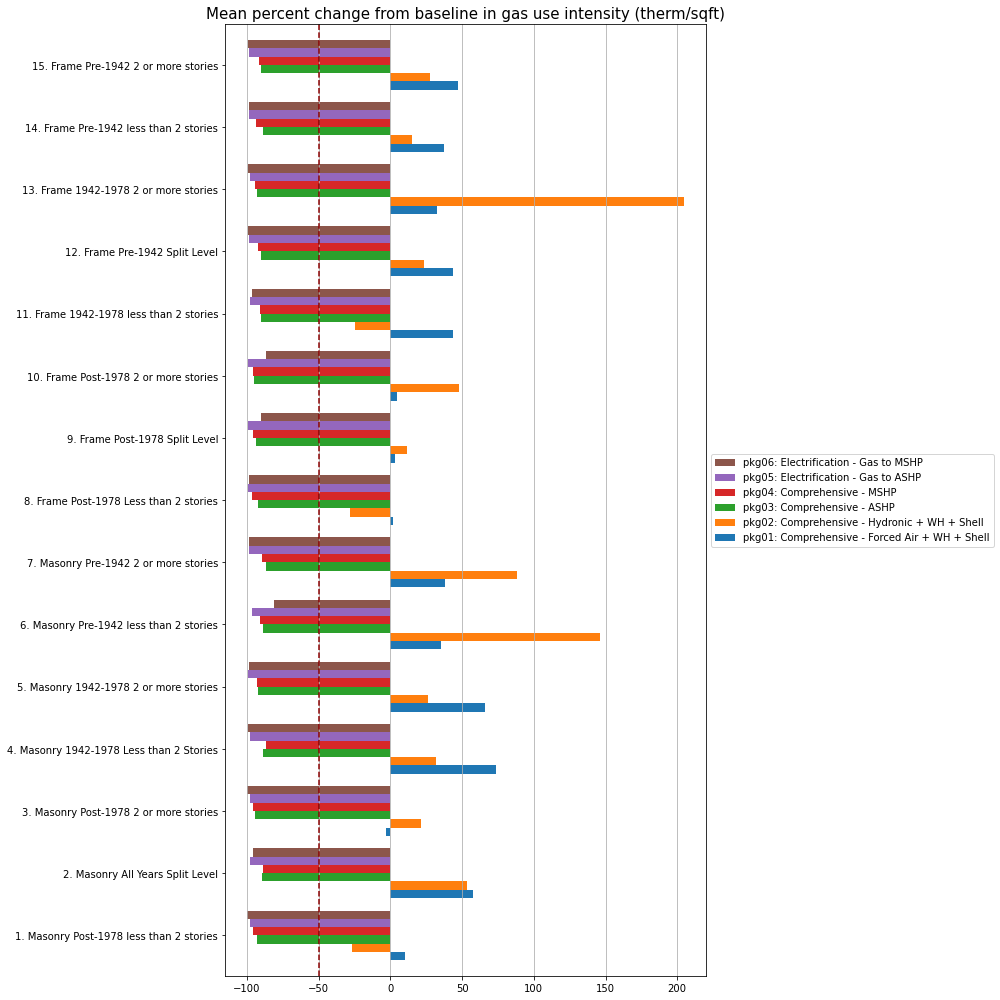

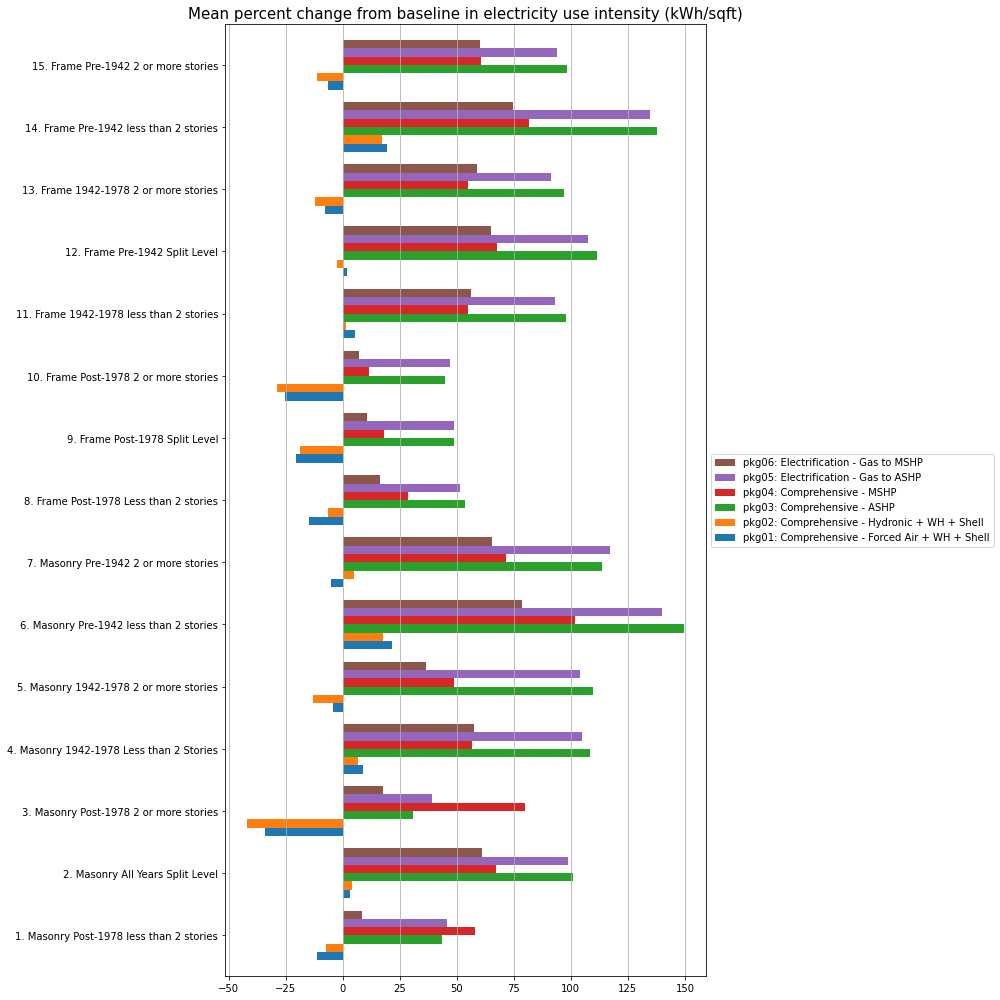

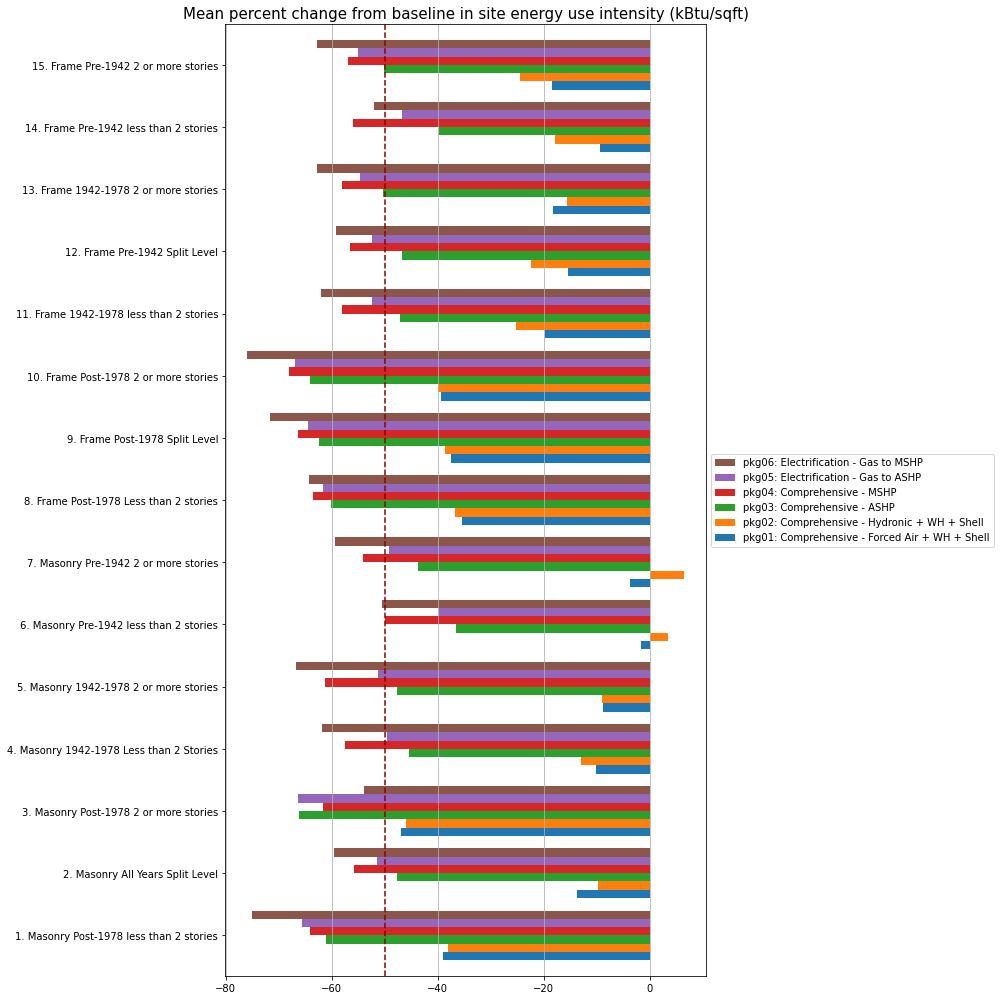

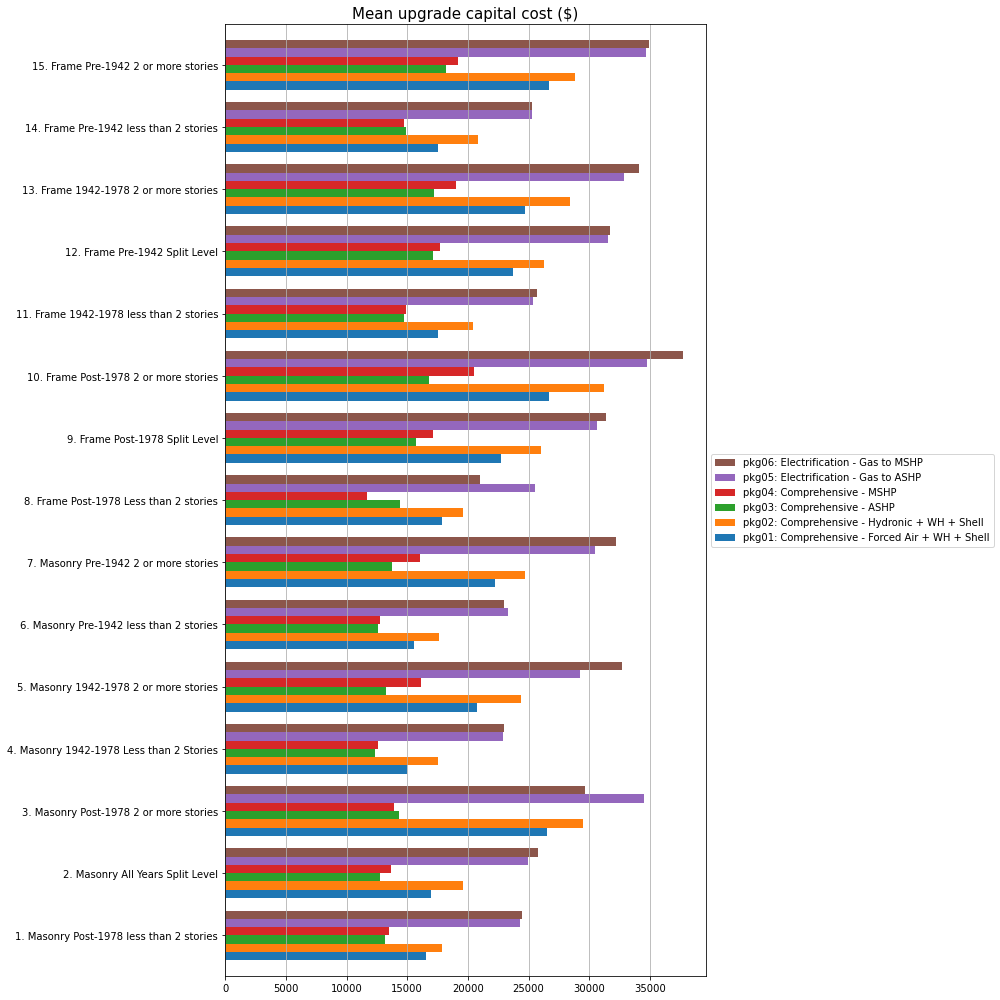

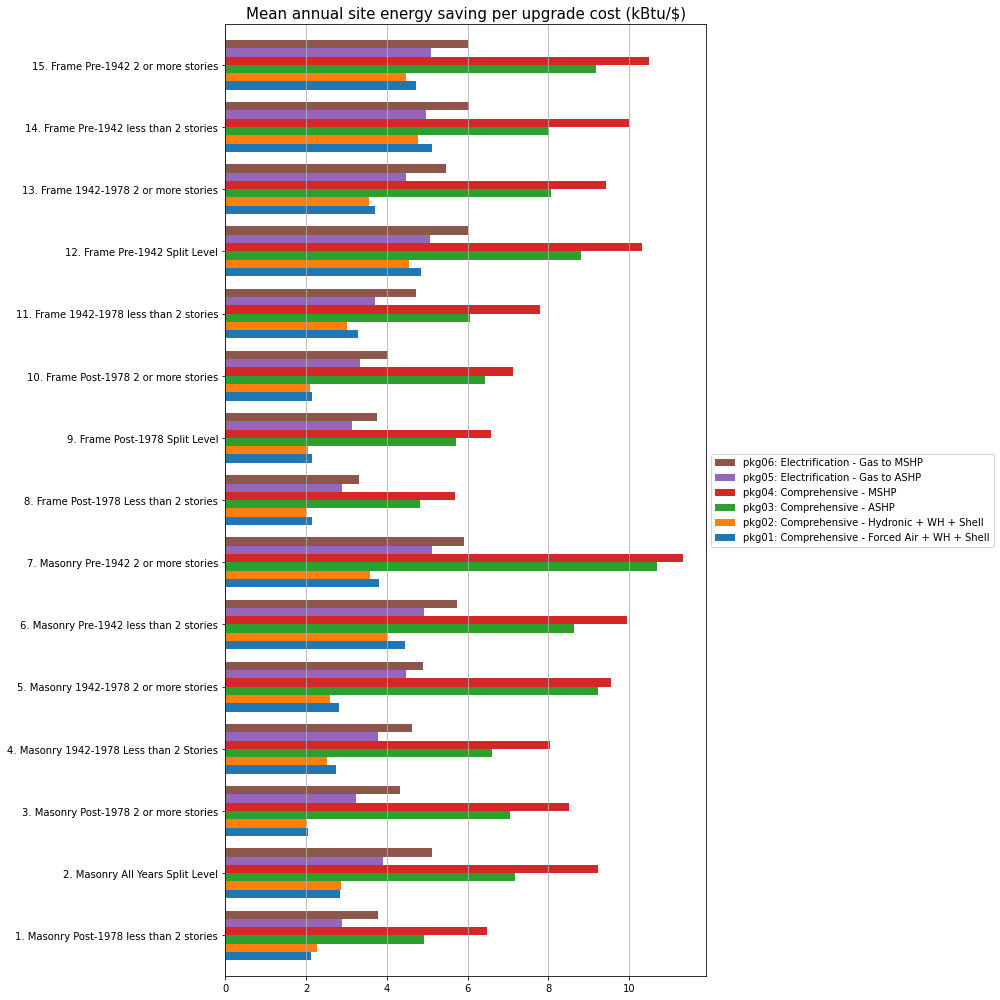

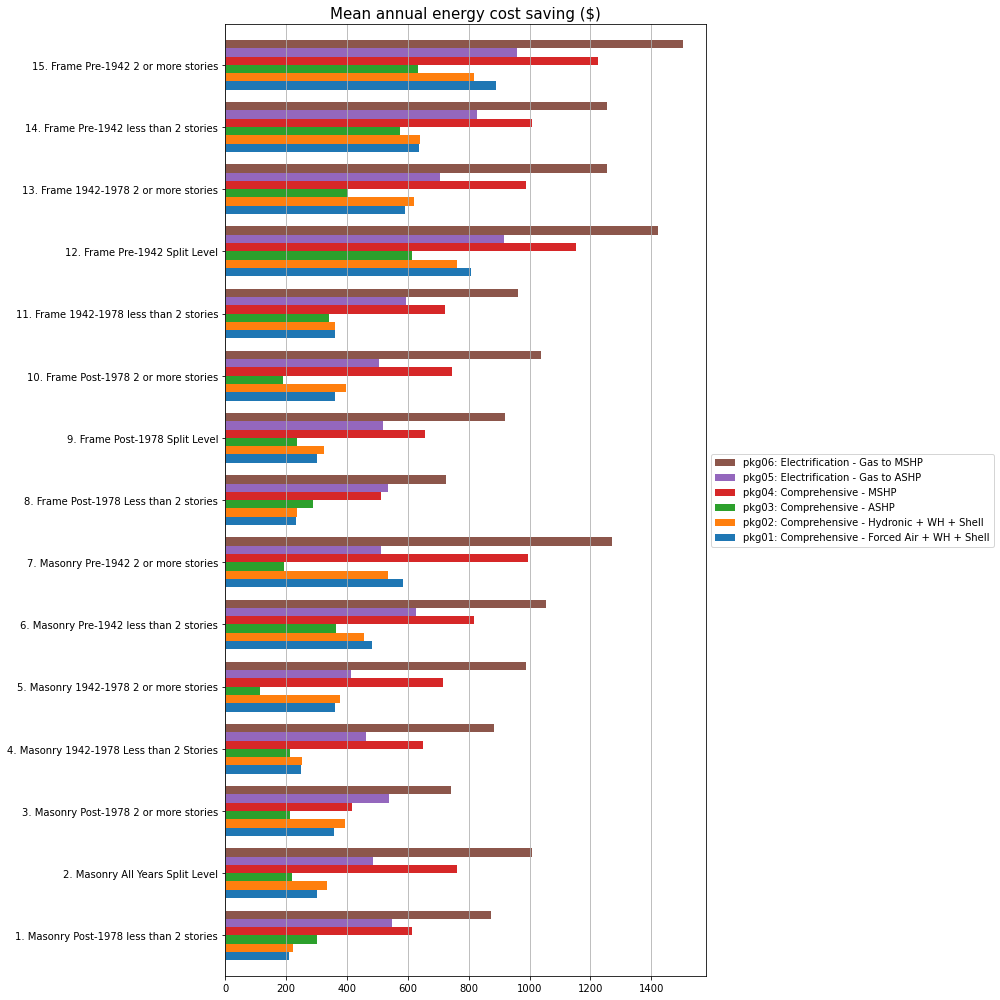

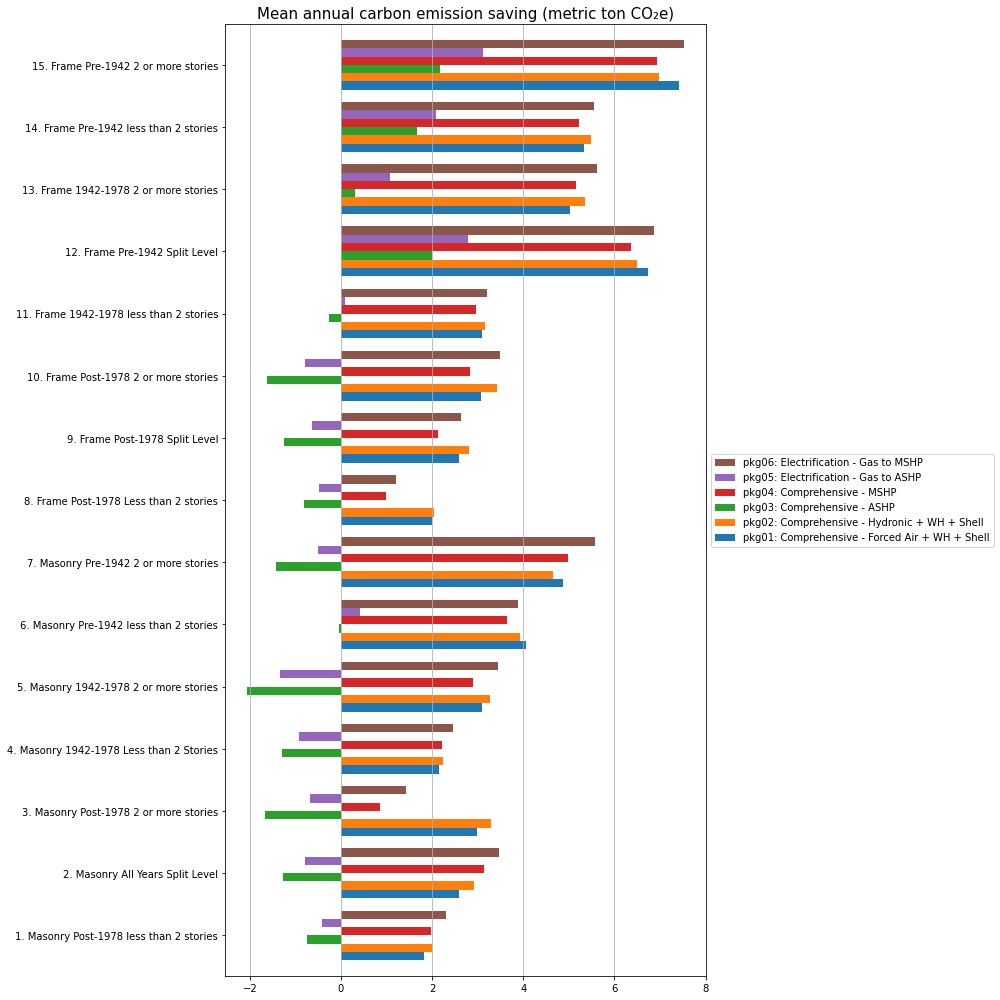

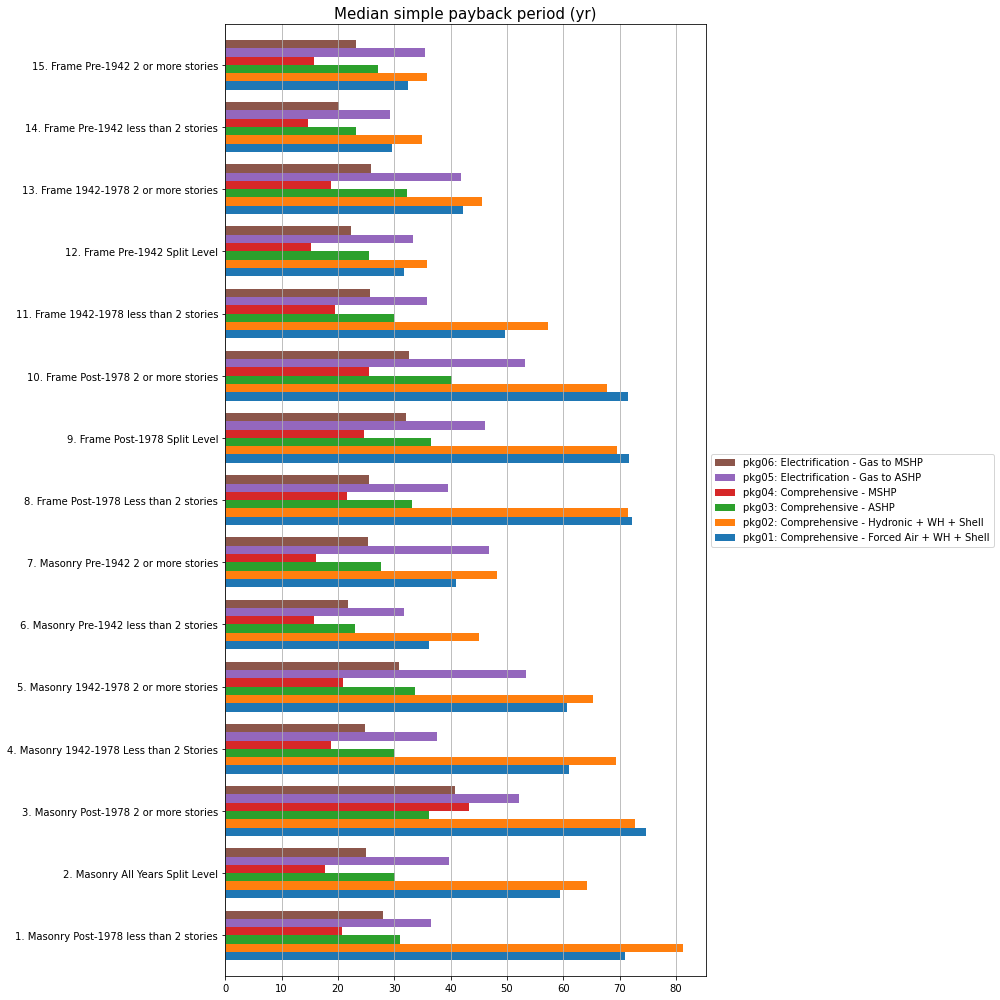

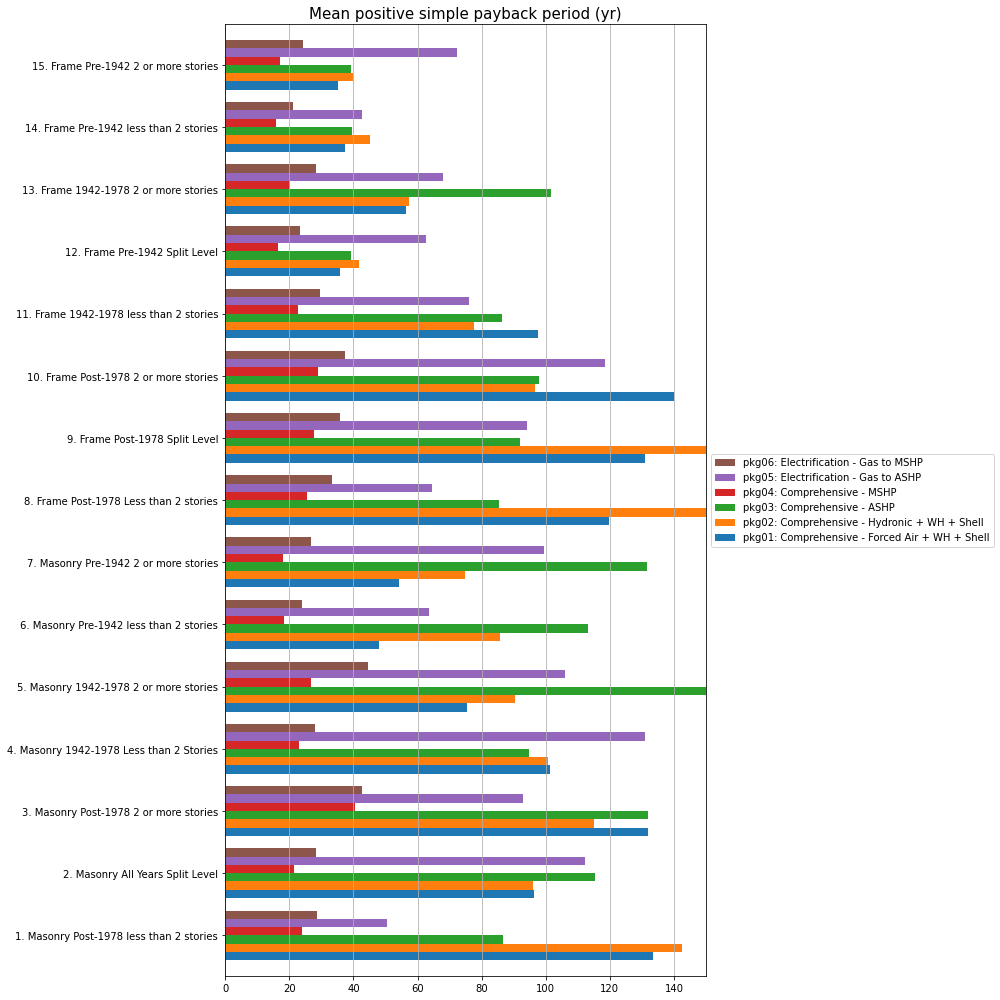

In [261]:
### other metrics to consider:
# monthly utility bills (gas + elec)
# carbon savings (require timeseries results)

zoom_in_plots = False # <-------

zoom_in_xlimits = {
    'mean_pct_delta_gas_eui': [None, None],
    'mean_pct_delta_elec_eui': [None, None],
    'mean_pct_delta_site_eui': [-25, None],
    'mean_upgrade_cost': [None, 10000],
    'mean_ann_kbtu_saved_per_dollar': [None, 500],
    'mean_ann_energy_cost_saving': [None, 2000],
    'mean_ann_metric_ton_co2e_saving': [None, 20],
    'median_simple_payback': [-70, 70],
}

# create subfolder for plots:
plot_path1 = os.path.join(plot_path, 'mean_values_by_prototype')
if not os.path.exists(plot_path1):
    os.mkdir(plot_path1)
print(f'plot dir: {plot_path1}\n')

title_ext = '' if fn_ext == '' else f' ({fn_ext.replace("_"," ").lstrip()})'

if NG_rate_multiplier == 1:
    para_labels = {
        'mean_pct_delta_gas_eui': 'Mean percent change from baseline in gas use intensity (therm/sqft)',
        'mean_pct_delta_elec_eui': 'Mean percent change from baseline in electricity use intensity (kWh/sqft)',
        'mean_pct_delta_site_eui': 'Mean percent change from baseline in site energy use intensity (kBtu/sqft)',
        'mean_upgrade_cost': 'Mean upgrade capital cost ($)',
        'mean_ann_kbtu_saved_per_dollar': 'Mean annual site energy saving per upgrade cost (kBtu/$)',
        'mean_ann_energy_cost_saving': f'Mean annual energy cost saving{title_ext} ($)',
        'mean_ann_metric_ton_co2e_saving': f'Mean annual carbon emission saving (metric ton CO₂e)',
        'median_simple_payback': f'Median simple payback period{title_ext} (yr)',
        'mean_pos_simple_payback': f'Mean positive simple payback period{title_ext} (yr)',
    }
else:
    para_labels = {
        'mean_ann_energy_cost_saving': f'Mean annual energy cost saving{title_ext} ($)',
        'median_simple_payback': f'Median simple payback period{title_ext} (yr)',
        'mean_pos_simple_payback': f'Mean positive simple payback period{title_ext} (yr)',
    }

    
for i, para_to_plot in enumerate(para_labels.keys(),1):
    
    zoom_ext = ''
    if zoom_in_plots:
        if len(list(x for x in zoom_in_xlimits[para_to_plot] if x is not None))>0:
            zoom_ext = '_zoomed'
    
    print(f'>> {i}. plotting {para_to_plot}{fn_ext}{zoom_ext}...')
    para_label = para_labels[para_to_plot]

    idx = groups2.loc[:,(('Baseline'),('HousingGroupNo'))].astype(str) +'. '+\
          groups2.loc[:,(('Baseline'),('HousingGroupName'))]
    UPi = groups2.set_index(idx)[para_to_plot]
    xmin = UPi.replace([np.inf, -np.inf], np.nan).min().min()
    xmax = UPi.replace([np.inf, -np.inf], np.nan).max().max()

    fig, ax = plt.subplots(ncols=1, nrows=1, sharex=True, sharey=True, figsize=(14, 14))

    ### Group 1: Intensive, fuel-agnostic upgrades (upg01-upg21)
    # Group 1A: (upg01-upg10) N=10
    UPi.plot(kind='barh', width=0.8, ax=ax)
    ax.xaxis.grid(True)
    if (para_to_plot[-3:]=='eui') & (xmin < -50):
        ax.axvline(x=-50, linestyle='--', color='darkred')
    ax.set_title(para_label, fontsize=15, y=1)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], ncol=1, loc='center left', bbox_to_anchor=(1, 0.5), fontsize='medium')
    ax.margins(y=0)
    
    if zoom_in_plots:
        [xmin, xmax] = zoom_in_xlimits[para_to_plot]
        if xmin is not None:
            ax.set_xlim(left = xmin)
        if xmax is not None:
            ax.set_xlim(right=xmax)
            
    if para_to_plot in ['median_simple_payback', 'mean_pos_simple_payback']:
        if xmax >= 150:
            ax.set_xlim(0,150)
    
    plt.tight_layout()
    
    filename = f'{iter_path}-comparison_{para_to_plot}{fn_ext}.pdf'
    fig.savefig(os.path.join(plot_path1, filename),
                bbox_inches='tight')


#### 2.3.2. plot mean values for Chicago avg per SFD

In [262]:
Wtchicago = groups2.loc[:,[('Baseline', 'HousingGroupName'),('Baseline', 'Chicago Prevalence')]
                       ]['Baseline'].set_index('HousingGroupName')

## add 'Chicago avg' and 'Chicago total'
groups_avg = groups2.set_index(('Baseline', 'HousingGroupName')).drop('Baseline', level=0, axis=1)
groups_avg.index.name = groups_avg.index.name[1]
groups_avg = groups_avg.stack(level=0).stack().unstack(level=0)
groups_avg['Chicago avg'] = np.where(np.isnan(groups_avg),0,groups_avg).dot(
    np.where(np.isnan(Wtchicago),0,Wtchicago)) # np.dot() ignoring nan

## add upgrade names
upgrade_name_map = summary_upgrades[['upgrade_no','upgrade_name']].copy()
upgrade_name_map.loc[:,'upgrade'] = upgrade_name_map['upgrade_no'].astype(int)
# upgrade_name_map.loc[:,'upgrade'] = 'upg' + \
#     upgrade_name_map['upgrade_no'].astype(int).astype(str).str.rjust(2,'0')
upgrade_name_map = upgrade_name_map.set_index('upgrade')['upgrade_name']

groups_avg = groups_avg.reset_index().rename({'level_0':'metrics','level_1':'upgrade_no'}, axis=1)
groups_avg['upgrade_no'] = groups_avg['upgrade_no'].str[3:5].astype(int)
groups_avg['upgrade_name'] = groups_avg['upgrade_no'].map(upgrade_name_map)
groups_avg = groups_avg.set_index(['metrics','upgrade_no','upgrade_name']).sort_index().reset_index()

### save a copy
groups_avg.to_csv(os.path.join(result_path,
                               'processed results',
                               f'upgrades_prototype_chicago_avg_results{fn_ext}.csv'),
                  index=True)
print(f'Natural gas rate multiplier: {NG_rate_multiplier}')
groups_avg

Natural gas rate multiplier: 1


HousingGroupName,metrics,upgrade_no,upgrade_name,Frame 1942-1978 2 or more stories,Frame 1942-1978 less than 2 stories,Frame Post-1978 2 or more stories,Frame Post-1978 Less than 2 stories,Frame Post-1978 Split Level,Frame Pre-1942 2 or more stories,Frame Pre-1942 Split Level,Frame Pre-1942 less than 2 stories,Masonry 1942-1978 2 or more stories,Masonry 1942-1978 Less than 2 Stories,Masonry All Years Split Level,Masonry Post-1978 2 or more stories,Masonry Post-1978 less than 2 stories,Masonry Pre-1942 2 or more stories,Masonry Pre-1942 less than 2 stories,Chicago avg
0,mean_ann_energy_cost_saving,1,Comprehensive - Forced Air + WH + Shell,591.510,361.390,361.090,231.120,303.150,891.170,807.790,636.530,360.470,248.040,303.150,356.030,210.720,582.780,483.260,476.398288
1,mean_ann_energy_cost_saving,2,Comprehensive - Hydronic + WH + Shell,620.410,359.790,397.290,236.410,325.280,816.410,760.400,639.730,377.220,251.920,334.620,393.380,223.030,535.490,455.840,458.773053
2,mean_ann_energy_cost_saving,3,Comprehensive - ASHP,401.810,340.630,190.660,289.410,234.770,632.830,613.340,573.300,113.170,213.640,220.260,213.450,302.300,191.640,364.070,325.359930
3,mean_ann_energy_cost_saving,4,Comprehensive - MSHP,988.330,722.310,743.830,512.520,656.100,1226.050,1152.250,1008.580,716.270,648.590,760.190,415.330,612.610,995.260,818.150,829.778808
4,mean_ann_energy_cost_saving,5,Electrification - Gas to ASHP,706.570,593.030,504.570,536.120,518.610,957.460,914.610,826.670,412.240,463.930,485.310,536.990,547.310,512.270,625.300,612.853002
5,mean_ann_energy_cost_saving,6,Electrification - Gas to MSHP,1255.400,962.240,1038.490,725.980,919.950,1504.530,1420.220,1254.580,988.500,884.110,1008.040,740.550,874.790,1270.990,1054.460,1085.167166
6,mean_ann_kbtu_saved_per_dollar,1,Comprehensive - Forced Air + WH + Shell,3.710,3.280,2.150,2.140,2.140,4.730,4.860,5.120,2.820,2.750,2.850,2.060,2.120,3.820,4.440,3.274835
7,mean_ann_kbtu_saved_per_dollar,2,Comprehensive - Hydronic + WH + Shell,3.550,3.020,2.110,2.010,2.060,4.470,4.560,4.770,2.590,2.530,2.860,2.000,2.270,3.590,4.010,3.099279
8,mean_ann_kbtu_saved_per_dollar,3,Comprehensive - ASHP,8.070,6.060,6.430,4.820,5.710,9.190,8.810,8.020,9.220,6.600,7.170,7.050,4.920,10.690,8.640,7.661241
9,mean_ann_kbtu_saved_per_dollar,4,Comprehensive - MSHP,9.440,7.800,7.130,5.680,6.580,10.490,10.330,10.010,9.550,8.050,9.220,8.520,6.490,11.340,9.960,8.745325


plot dir: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_comprehensive/processed results/plots/mean_values_chicago_avg

Plotting Chicago avg: mean_ann_energy_cost_saving...
    - Group1
Plotting Chicago avg: mean_ann_kbtu_saved_per_dollar...
    - Group1
Plotting Chicago avg: mean_ann_metric_ton_co2e_saving...
    - Group1
Plotting Chicago avg: mean_pct_delta_elec_eui...
    - Group1
Plotting Chicago avg: mean_pct_delta_gas_eui...
    - Group1
Plotting Chicago avg: mean_pct_delta_site_eui...
    - Group1
Plotting Chicago avg: mean_pos_simple_payback...
    - Group1
Plotting Chicago avg: mean_upgrade_cost...
    - Group1
Plotting Chicago avg: median_simple_payback...
    - Group1
Plotting Chicago avg: pct_pos_simple_payback...
    - Group1


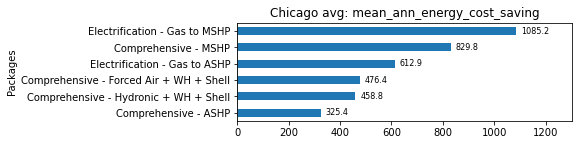

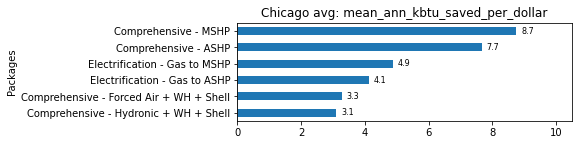

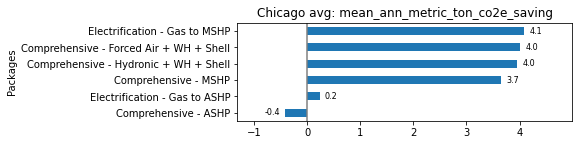

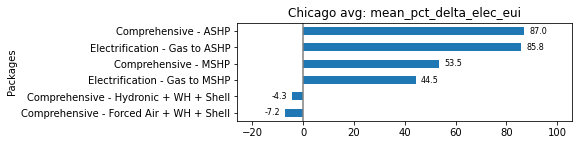

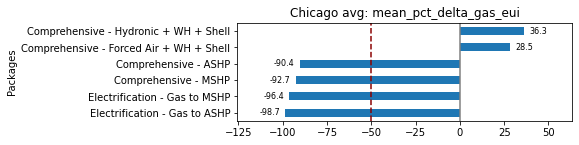

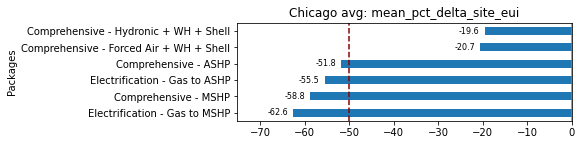

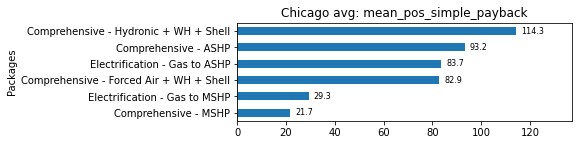

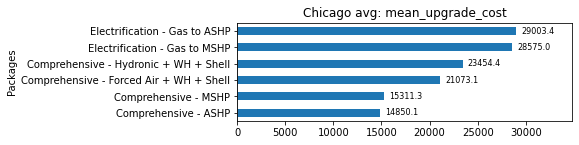

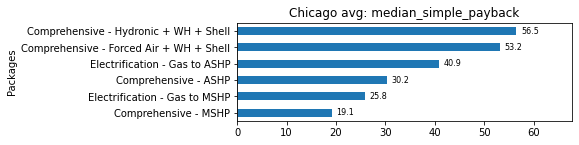

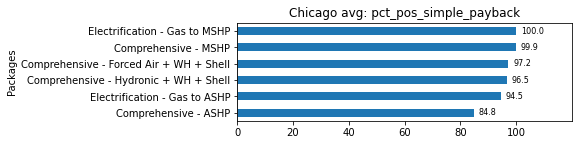

In [263]:
para_to_plot = 'Chicago avg' # <------

upgrade_sets = {
    'Packages': range(1, N_upgrades+1),
}
upgrade_set_colors = {
    'Packages': 'tab:blue',
}

# create subfolder for plots:
plot_path2 = os.path.join(plot_path, 'mean_values_chicago_avg')
if not os.path.exists(plot_path2):
    os.mkdir(plot_path2)
print(f'plot dir: {plot_path2}\n')

if NG_rate_multiplier == 1: 
    metrics_to_plot = groups_avg['metrics'].unique()
else:
    metrics_to_plot = ['mean_ann_energy_cost_saving', 'median_simple_payback']
    
for metric in metrics_to_plot:
    title_ext = '' if fn_ext == '' else f' ({fn_ext.replace("_"," ").lstrip()})'
    title = f'{para_to_plot}: {metric}{title_ext}'
    print(f'Plotting {title}...')
    
    for n, up in enumerate(upgrade_sets.keys(),1):
        print(f'    - Group{n}')
        
        groupi = groups_avg[(groups_avg['metrics']==metric) & 
                              (groups_avg['upgrade_no'].isin(upgrade_sets[up]))][[
            'upgrade_name',para_to_plot]].set_index('upgrade_name').sort_values(by=para_to_plot)
        groupi.index.name = up
        
        ht = len(groupi)
        fig, ax = plt.subplots(figsize=(6, 0.3*ht))
        groupi.plot.barh(color=upgrade_set_colors[up], legend=False, title=title, ax=ax)
        
        # For each bar: Place a label ############################
        rects = ax.patches
        for rect in rects:
            # Get X and Y placement of label from rect.
            x_value = rect.get_width()
            y_value = rect.get_y() + rect.get_height() / 2

            # Number of points between bar and label. Change to your liking.
            space = 5
            # Vertical alignment for positive values
            ha = 'left'

            # If value of bar is negative: Place label left of bar
            if x_value < 0:
                # Invert space to place label to the left
                space *= -1
                # Horizontally align label at right
                ha = 'right'

            # Use X value as label and format number with one decimal place
            label = "{:.1f}".format(x_value)

            # Create annotation
            plt.annotate(
                label,                      # Use `label` as label
                (x_value, y_value),         # Place label at end of the bar
                xytext=(space, 0),          # Horizontally shift label by `space`
                textcoords="offset points", # Interpret `xytext` as offset in points
                va='center',                # Vertically center label
                ha=ha,                      # Horizontally align label differently for
                fontsize=8)                 # positive and negative values. 
            
        ax.margins(x=0.2)    
        ax.axvline(x=0, linestyle='-', color='gray')
        if (metric[-3:]=='eui') & (ax.get_xlim()[0] < -50):
            ax.axvline(x=-50, linestyle='--', color='darkred')
        
        filename = f'upgrades_{iteration}-{para_to_plot}_{metric}{fn_ext}.pdf'
        fig.savefig(os.path.join(plot_path2, filename),
                    bbox_inches='tight')
        

#### 2.3.4. plot metrics distribution
Run cell below to load df for plots

In [264]:
load_df_for_plot_below_from_file = False # <-----

if load_df_for_plot_below_from_file:
    NG_rate_multiplier = 1 # 1 or 3 <----- This controls what to plot in both '2.3.1.' and '2.3.2.' plots
 
    if NG_rate_multiplier > 1:
        fn_ext = f'_{NG_rate_multiplier}x_gas_prices' # file name extension to add to relevant results
    else:
        fn_ext = ''

    all_proto_upgrades = pd.read_csv(os.path.join(result_path, 'processed results', 'all_upgrades_by_prototype_combined.csv'))
    
    print(f'"all_proto_upgrades{fn_ext}" df loaded from file.')
    N_upgrades = all_proto_upgrades['package_no'].unique().max()
    print(f'   total number of packages: {N_upgrades}')
    
    display(all_proto_upgrades)


plot dir: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_comprehensive/processed results/plots/distribution_by_prototype

>> 1. plotting pct_delta_gas_eui...


IndexError: single positional indexer is out-of-bounds

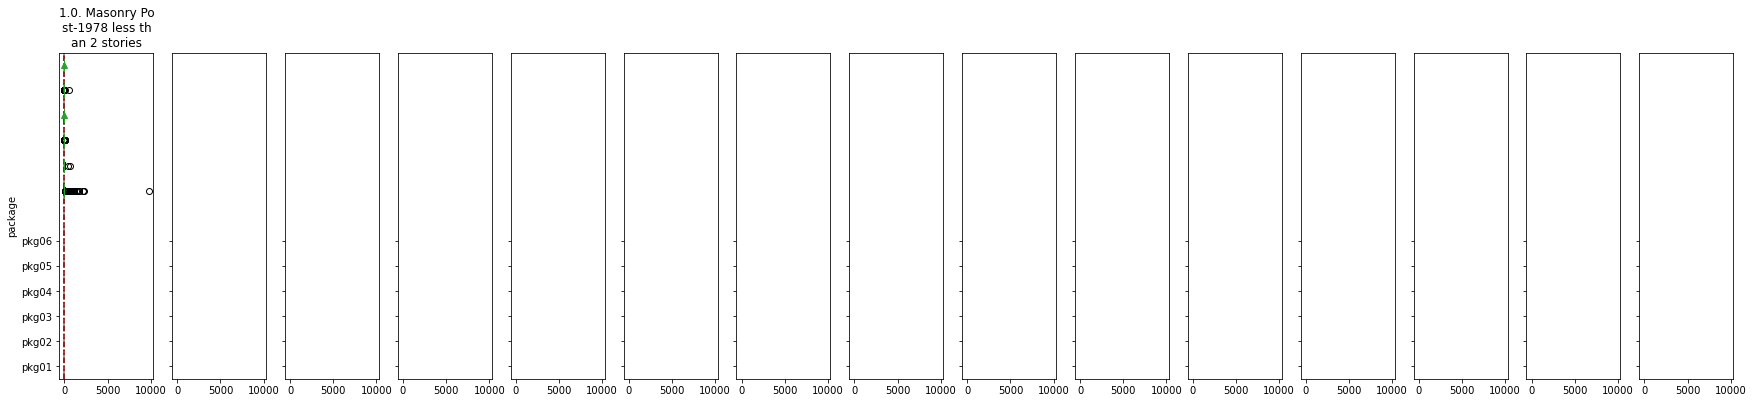

In [265]:
### other metrics to consider:
# monthly utility bills (gas + elec)
# carbon savings (require timeseries results)

# create subfolder for plots:
plot_path4 = os.path.join(plot_path, 'distribution_by_prototype')
if not os.path.exists(plot_path4):
    os.mkdir(plot_path4)
print(f'plot dir: {plot_path4}\n')

title_ext = '' if fn_ext == '' else f' ({fn_ext.replace("_"," ").lstrip()})'

## modifying payback periods, cap either ends at [100,-100] 
all_proto_upgrades.loc[(all_proto_upgrades[all_proto_upgrades['simple_payback']>100]).index,
                       'simple_payback'] = 100
all_proto_upgrades.loc[(all_proto_upgrades[all_proto_upgrades['simple_payback']<-100]).index,
                       'simple_payback'] = -100

if NG_rate_multiplier == 1:
    para_labels = {
        'pct_delta_gas_eui': 'Percent change from baseline in gas use intensity (therm/sqft)',
        'pct_delta_elec_eui': 'Percent change from baseline in electricity use intensity (kWh/sqft)',
        'pct_delta_site_eui': 'Percent change from baseline in site energy use intensity (kBtu/sqft)',
        'upgrade_cost': 'Upgrade capital cost ($)',
        'ann_kbtu_saved_per_dollar': 'Annual site energy saving per upgrade cost (kBtu/$)',
        'ann_energy_cost_saving': f'Annual site energy cost saving{title_ext}',
        'ann_metric_ton_co2e_saving': f'Annual carbon emission saving (metric ton CO₂e)',
        'simple_payback': f'Simple payback period (yr){title_ext}',
    }
else:
    para_labels = {
        'ann_energy_cost_saving': f'Annual site energy cost saving{title_ext}',
        'simple_payback': f'Simple payback period (yr){title_ext}',
    }

cols_to_match = list(f'pkg{n:02d}' for n in range(1,N_upgrades+1))

for i, para_to_plot in enumerate(para_labels.keys(),1):
    
    print(f'>> {i}. plotting {para_to_plot}{fn_ext}...')
    xmin = all_proto_upgrades[para_to_plot].min(); xmax = all_proto_upgrades[para_to_plot].max()
    
    fig, axes = plt.subplots(ncols=15, nrows=1, sharex=True, sharey=True, figsize=(30, 6))
    for h in range(1,16):
        ax = axes[h-1]
        p = all_proto_upgrades.query('HousingGroupNo==@h')[['HousingGroupNo','HousingGroupName',
                                                            'package_no', para_to_plot]]
        lab = f'{p["HousingGroupNo"].iloc[0]}. {p["HousingGroupName"].iloc[0]}'
        lab = '\n'.join([lab[i:i+15] for i in range(0, len(lab), 15)]) # break up long string
        p.loc[:,'package_no'] = 'pkg'+p['package_no'].astype(str).str.zfill(2)
        p = p.sort_values(by='package_no')
        p = p.set_index([p.index, 'package_no'])[
            para_to_plot].unstack(level=-1).dropna(
            axis=0, how='all')
        
        ### show all upgrades
        for col in set(cols_to_match)-set(p.columns):
            p[col] = np.nan
        p = p.sort_index(axis=1).reset_index(drop=True)
    
        if para_to_plot == 'simple_payback':
            showmeans = False
        else:
            showmeans = True
            
        try:
            p.boxplot(ax=ax, vert=False, grid=False, showmeans=showmeans)
        except:
            pass

        ax.set_title(lab)
        if h==1:
            ax.set_ylabel('package')
        ax.axvline(x=0, linestyle='-.', color='gray')
        if (para_to_plot[-3:]=='eui') & (xmin < -50):
            ax.axvline(x=-50, linestyle='--', color='darkred')
            
        ax.set_yticks(range(1, 1+N_upgrades))
        ax.set_yticklabels(cols_to_match)
        
    para_label = para_labels[para_to_plot]
    fig.suptitle(para_label, fontsize=20, y=1.03)
    plt.tight_layout()
    
    filename = os.path.join(plot_path4, f'{iter_path}-distribution_{para_to_plot}{fn_ext}.pdf')
    fig.savefig(filename, bbox_inches='tight')
